# Wrangling and Analyzing Twitter Dog Data

## Table of Contents

1. <a href="#intro">Introduction</a>
2. <a href="#intro">Data Wrangling</a>
    - <a href="#gather">Gathering Data</a>
    - <a href="#assess">Assessing Data</a>
    - <a href="#clean">Cleaning Data</a>
    - <a href="#store">Storing Data</a>
3. <a href="#analysis">Analysis</a>
    - <a href="#RQ1">Research Question 1: What is the average dog rating? Has the average rating changed over time?</a>
    - <a href="#RQ2">Research Question 2: Which dog breed is most popular?</a>
    - <a href="#RQ3">Research Question 3: Is there a relationship between number of retweets, number of favorites and ratings?</a>
4. <a href="#conclusion">Conclusion</a>

<a id='intro'></a>
## Introduction
This project aims to wrangle and analyze a dataset based on the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? [Because "they're good dogs Brent"](https://knowyourmeme.com/memes/theyre-good-dogs-brent). WeRateDogs has over 8.7 million followers (June 2020) and has received international media coverage.
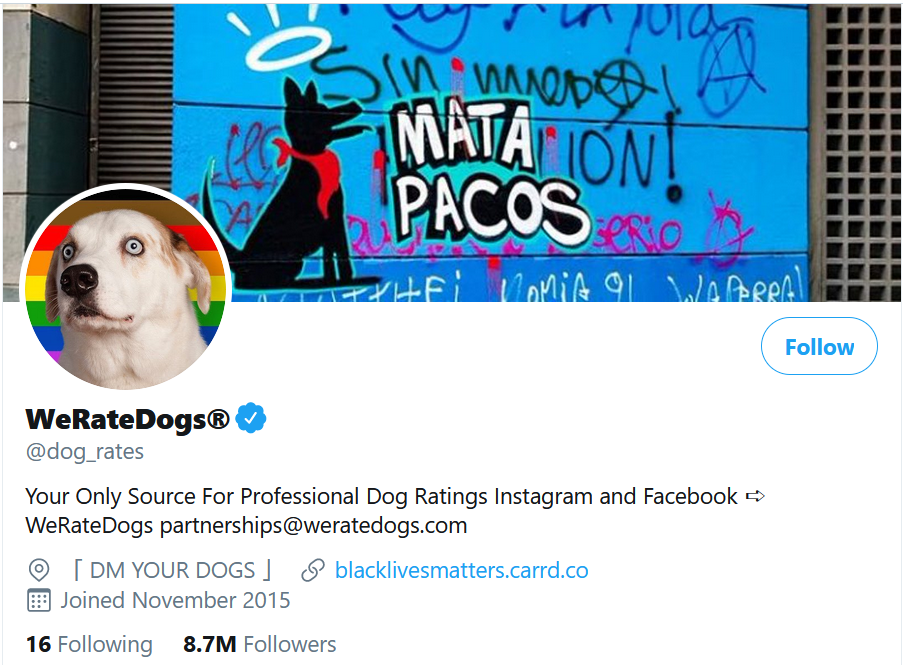

The goal of this project: wrangling WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from pandas import option_context
from PIL import Image
from io import BytesIO

<a id='wrangling'></a>
## Data Wrangling

<a id='gather'></a>
### Gathering Data
The data for this project consists of 
- The WeRateDogs Twitter archive
- Tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.
- Additional tweet data gathered from the Twitter API

In [2]:
# Reading in the twitter archive data
twitter_archive = pd.read_csv('data/twitter-archive-enhanced.csv')
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [3]:
# Programmatically downloading the tweet image predictions, and saving them to a file

# Make directory if it doesn't already exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
        file.write(response.content)
        
predictions = pd.read_csv('image_predictions/image-predictions.tsv', sep = '\t', encoding = 'utf-8')                
predictions.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [11]:
# creating an API object to gather Twitter data
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
# https://stackoverflow.com/questions/27900451/convert-tweepy-status-object-into-json
api = tweepy.API(auth, wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True, 
                 parser=tweepy.parsers.JSONParser())

# https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
# record the start time
start_time = time.time()

# https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
# https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
# get access to all tweet content for the tweet_ids in twitter_archive + write JSON to a file
error_list = []

with open('tweet_json.txt', 'w') as file:  
    for tweet_id in twitter_archive['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            file.write(json.dumps(tweet) + '\n')
        # Catch the exceptions
        except:
            print("error of id: " + str(tweet_id))
            error_list.append(tweet_id)

# Calculate the time of execution
end_time = time.time()
print(end_time - start_time)


error of id: 888202515573088257
error of id: 873697596434513921
error of id: 872668790621863937
error of id: 872261713294495745
error of id: 869988702071779329
error of id: 866816280283807744
error of id: 861769973181624320
error of id: 856602993587888130
error of id: 851953902622658560
error of id: 845459076796616705
error of id: 844704788403113984
error of id: 842892208864923648
error of id: 837366284874571778
error of id: 837012587749474308
error of id: 829374341691346946
error of id: 827228250799742977
error of id: 812747805718642688
error of id: 802247111496568832
error of id: 779123168116150273
error of id: 775096608509886464
error of id: 771004394259247104
error of id: 770743923962707968
error of id: 759566828574212096
Rate limit reached. Sleeping for: 743
error of id: 754011816964026368
error of id: 680055455951884288
Rate limit reached. Sleeping for: 744
1906.451339006424


In [12]:
# number of errors
print("The number of errors is", len(error_list))

The number of errors is 25


In [6]:
api_result = pd.read_json("tweet_json.txt", orient = 'index')
api_result.head()

contributors  coordinates          created_at  \
1991-02-08 13:48:08.022790149           NaN          NaN 2015-11-15 22:32:08   
1991-02-08 16:08:05.002620928           NaN          NaN 2015-11-15 23:05:30   
1991-02-08 17:16:52.701032449           NaN          NaN 2015-11-15 23:21:54   
1991-02-08 20:17:06.329800704           NaN          NaN 2015-11-16 00:04:52   
1991-02-08 21:40:48.165822465           NaN          NaN 2015-11-16 00:24:50   

                              display_text_range  \
1991-02-08 13:48:08.022790149           [0, 131]   
1991-02-08 16:08:05.002620928           [0, 139]   
1991-02-08 17:16:52.701032449           [0, 130]   
1991-02-08 20:17:06.329800704           [0, 137]   
1991-02-08 21:40:48.165822465           [0, 120]   

                                                                        entities  \
1991-02-08 13:48:08.022790149  {'hashtags': [], 'media': [{'display_url': 'pi...   
1991-02-08 16:08:05.002620928  {'hashtags': [], 'media': [{'display_url': 'pi...   
1991-02-08 17:16:52.701032449  {'hashtags': [], 'media': [{'display_url': 'pi...   
1991-02-08 20:17:06.329800704  {'hashtags': [], 'media': [{'display_url': 'pi...   
1991-02-08 21:40:48.165822465  {'hashtags': [], 'media': [{'display_url': 'pi...   

                                                               extended_entities  \
1991-02-08 13:48:08.022790149  {'media': [{'display_url': 'pic.twitter.com/BL...   
1991-02-08 16:08:05.002620928  {'media': [{'display_url': 'pic.twitter.com/r7...   
1991-02-08 17:16:52.701032449  {'media': [{'display_url': 'pic.twitter.com/y6...   
1991-02-08 20:17:06.329800704  {'media': [{'display_url': 'pic.twitter.com/DW...   
1991-02-08 21:40:48.165822465  {'media': [{'display_url': 'pic.twitter.com/4B...   

                               favorite_count  favorited  \
1991-02-08 13:48:08.022790149            2382          0   
1991-02-08 16:08:05.002620928             120          0   
1991-02-08 17:16:52.701032449             111          0   
1991-02-08 20:17:06.329800704             266          0   
1991-02-08 21:40:48.165822465              96          0   

                                                                       full_text  \
1991-02-08 13:48:08.022790149  Here we have a Japanese Irish Setter. Lost eye...   
1991-02-08 16:08:05.002620928  This is a western brown Mitsubishi terrier. Up...   
1991-02-08 17:16:52.701032449  Here is a very happy pup. Big fan of well-main...   
1991-02-08 20:17:06.329800704  This is a purebred Piers Morgan. Loves to Netf...   
1991-02-08 21:40:48.165822465  Here we have a 1949 1st generation vulpix. Enj...   

                               geo  \
1991-02-08 13:48:08.022790149  NaN   
1991-02-08 16:08:05.002620928  NaN   
1991-02-08 17:16:52.701032449  NaN   
1991-02-08 20:17:06.329800704  NaN   
1991-02-08 21:40:48.165822465  NaN   

                                                     ...                          \
1991-02-08 13:48:08.022790149                        ...                           
1991-02-08 16:08:05.002620928                        ...                           
1991-02-08 17:16:52.701032449                        ...                           
1991-02-08 20:17:06.329800704                        ...                           
1991-02-08 21:40:48.165822465                        ...                           

                               quoted_status  quoted_status_id  \
1991-02-08 13:48:08.022790149            NaN               NaN   
1991-02-08 16:08:05.002620928            NaN               NaN   
1991-02-08 17:16:52.701032449            NaN               NaN   
1991-02-08 20:17:06.329800704            NaN               NaN   
1991-02-08 21:40:48.165822465            NaN               NaN   

                              quoted_status_id_str  quoted_status_permalink  \
1991-02-08 13:48:08.022790149                  NaN                      NaN   
1991-02-08 16:08:05.002620928                  NaN                      

In [15]:
# Read data from the text file line by line 
tweets = {'tweet_id': [], 'retweet_count': [], 'favorite_count': [], 'created_at': [], 'retweet': []}

with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        tweet_data = json.loads(line)
        tweets['tweet_id'].append(tweet_data['id'])
        tweets['retweet_count'].append(tweet_data['retweet_count'])
        tweets['favorite_count'].append(tweet_data['favorite_count'])
        tweets['created_at'].append(tweet_data['created_at'])
        try:
            retweet_checker = tweet_data['retweeted_status']
            tweets['retweet'].append(True)
        except KeyError:
            # The tweet is not a retweet 
            tweets['retweet'].append(False)    
api_tweets = pd.DataFrame(tweets, columns=['tweet_id', 'favorite_count', 'retweet_count', 'created_at', 'retweet'])
api_tweets.head()

tweet_id  favorite_count  retweet_count  \
0  892420643555336193           35815           7583   
1  892177421306343426           30914           5622   
2  891815181378084864           23266           3720   
3  891689557279858688           39083           7765   
4  891327558926688256           37343           8360   

                       created_at  retweet  
0  Tue Aug 01 16:23:56 +0000 2017    False  
1  Tue Aug 01 00:17:27 +0000 2017    False  
2  Mon Jul 31 00:18:03 +0000 2017    False  
3  Sun Jul 30 15:58:51 +0000 2017    False  
4  Sat Jul 29 16:00:24 +0000 2017    False

In [16]:
# storing the api data in a csv
api_tweets.to_csv('twitter_api_data.csv', index=False, encoding = 'utf-8')

<a id='assess'></a>
### Assessing Data
 - We only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
 - The dataset is assessed for cleanliness and tidiness issues visually and programmatically, cleaning includes merging individual pieces of data according to the rules of tidy data.

#### Assessing the twitter archive data

In [4]:
# displaying the twitter archive
twitter_archive

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
5     891087950875897856                    NaN                  NaN   
6     890971913173991426                    NaN                  NaN   
7     890729181411237888                    NaN                  NaN   
8     890609185150312448                    NaN                  NaN   
9     890240255349198849                    NaN                  NaN   
10    890006608113172480                    NaN                  NaN   
11    889880896479866881                    NaN                  NaN   
12    889665388333682689                    NaN                  NaN   
13    889638837579907072                    NaN                  NaN   
14    889531135344209921                    NaN                  NaN   
15    889278841981685760                    NaN                  NaN   
16    888917238123831296                    NaN                  NaN   
17    888804989199671297                    NaN                  NaN   
18    888554962724278272                    NaN                  NaN   
19    888202515573088257                    NaN                  NaN   
20    888078434458587136                    NaN                  NaN   
21    887705289381826560                    NaN                  NaN   
22    887517139158093824                    NaN                  NaN   
23    887473957103951883                    NaN                  NaN   
24    887343217045368832                    NaN                  NaN   
25    887101392804085760                    NaN                  NaN   
26    886983233522544640                    NaN                  NaN   
27    886736880519319552                    NaN                  NaN   
28    886680336477933568                    NaN                  NaN   
29    886366144734445568                    NaN                  NaN   
...                  ...                    ...                  ...   
2326  666411507551481857                    NaN                  NaN   
2327  666407126856765440                    NaN                  NaN   
2328  666396247373291520                    NaN                  NaN   
2329  666373753744588802                    NaN                  NaN   
2330  666362758909284353                    NaN                  NaN   
2331  666353288456101888                    NaN                  NaN   
2332  666345417576210432                    NaN                  NaN   
2333  666337882303524864                    NaN                  NaN   
2334  666293911632134144                    NaN                  NaN   
2335  666287406224695296                    NaN                  NaN   
2336  666273097616637952                    NaN                  NaN   
2337  666268910803644416                    NaN                  NaN   
2338  666104133288665088                    NaN                  NaN   
2339  666102155909144576                    NaN                  NaN   
2340  666099513787052032                    NaN                  NaN   
2341  666094000022159362                    NaN                  NaN   
2342  666082916733198337                    NaN                  NaN   
2343  666073100786774016                    NaN                  NaN   
2344  666071193221509120                    NaN                  NaN   
2345  666063827256086533                    NaN                  NaN   
2346  666058600524156928                    NaN                  NaN   
2347  666057090499244032                    NaN                  NaN   
2348  666055525042405380                    NaN                  NaN   
2349  666051853826850816                    NaN         

Additionally to displaying the dataframe within this notebook, I visually assessed the csv-file using Google Sheets. 

The twitter archive that was provided by Udacity, has 2356 rows and 17 columns. Upon visual assessment, the following quality issues are visible: 
- The twitter archive is including some retweets, these should be dropped from the dataset as I am only interested in original ratings including images. 
- Some dog names are in lowercase, and don't seem to be dog names, but words like "such" or "as" - I am going to further assess this programmatically. 
- Ratings had a number of issues:
    - Notations wrongly considered as ratings, e.g. 24/7, 9/11, 3 1/2, 4/20 ...
    - Decimal ratings were not correctly retrieved, e.g. 9.75
    - Some ratings were very low or very high. After following the tweet url for a random sample, I determined, that most of them are ratings of camouflaged dogs, other animals (e.g. a caterpillar or a cow), or in one case Snoop Dogg.
- Some dogs have multiple dog_stages assigned to them, I am going to assess this further programmatically. 
- A lot of the "in_reply_to" tweets do not include a link to a tweet and picture. As stated above, I am only interested in original ratings including images. 

Additionally, doggo, floofer, pupper, and puppo could be converted to a dog_stage variable to achieve data tidiness. 

Following the visual assessment, I am going to programmatically assess *twitter_archive*.

In [5]:
# assessing data types and null values
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- The columns *tweet_id*, *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, and *retweeted_status_user_id* are ints or floats, but should be strings. 
- The *timestamp* and *retweeted_status_timestamp* features should be datetime objects.
- Dog *name* and the dog stages do not have null values, it seems their null values are represented by a string "None" instead of Python's None. 

In [6]:
# checking for duplicate tweets
sum(twitter_archive['tweet_id'].duplicated())

0

Great, the twitter archive does not include duplicate tweets. Next, I am looking at the lowercase dog names

In [7]:
# assessing lowercase dog names
twitter_archive[twitter_archive.name.str.islower() == True].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

The programmatic assessment confirms what I already suspected in the visual assessment: all lowercase names are not names, but wrongly extracted terms mistaken for names. Next, I am having a closer look at the rating_numerators. 

In [8]:
# assessing rating numerators
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [9]:
# Having a closer look at the data with numerators over 14
# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
high_numerators = [420, 15, 75, 80, 20, 24, 26, 33, 50, 60, 165, 84, 88,
                   144, 182, 143, 666, 960, 1776, 17, 27, 45, 99, 121, 204]

unusual_nums = twitter_archive[twitter_archive['rating_numerator'].isin(high_numerators)]
unusual_tweets = unusual_nums.sort_values('rating_numerator',ascending=False)

# https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
with option_context('display.max_colwidth', 400):
    display(unusual_tweets[['tweet_id','rating_numerator', 'text']])

tweet_id  rating_numerator  \
979   749981277374128128              1776   
313   835246439529840640               960   
189   855860136149123072               666   
188   855862651834028034               420   
2074  670842764863651840               420   
1120  731156023742988288               204   
290   838150277551247360               182   
902   758467244762497024               165   
1779  677716515794329600               144   
1634  684225744407494656               143   
1635  684222868335505415               121   
1228  713900603437621249                99   
1843  675853064436391936                88   
433   820690176645140481                84   
1254  710658690886586372                80   
695   786709082849828864                75   
340   832215909146226688                75   
1351  704054845121142784                60   
1202  716439118184652801                50   
1274  709198395643068416                45   
763   778027034220126208                27   
1712  680494726643068929                26   
516   810984652412424192                24   
1663  682808988178739200                20   
55    881633300179243008                17   
285   838916489579200512                15   
291   838085839343206401                15   

                                                                                                                                                                           text  
979                                                                                              This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh  
313                                                                          @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho  
189                                       @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10  
188                                                                                      @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research  
2074                                                                                        After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY  
1120                                                  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv  
290                                                                                                                                                          @markhoppus 182/10  
902                                                                                              Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE  
1779                                                                                                     IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq  
1634                                             Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3  
1635                               Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55  
1228                                                                              Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1  
1843                                                                Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw  
433                                                                         The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd  
1254                                                     

This assessment showed a number of quality issues, I am going to list them out here, and will then decide at the end of the assessment which ones need to be cleaned. 
- Multiple dogs being rated for tweet_ids: 731156023742988288, 758467244762497024, 684225744407494656, 684222868335505415, 713900603437621249, 675853064436391936, 820690176645140481, 710658690886586372, 704054845121142784, 709198395643068416 	
- No image for tweet_ids: 835246439529840640, 855860136149123072, 855862651834028034, 838150277551247360, 677716515794329600, 682808988178739200, 881633300179243008      
- Snoop Dogg being rated: 670842764863651840,
- RT: 832215909146226688, 838916489579200512
- Wrongly extracted decimal: 786709082849828864 (9.75 in text, mistaken for 75),778027034220126208 (11.27 in text, mistaken for 27),680494726643068929 (multiple dogs, 11.26 mistaken for 26)
- 50/50 mistaken as notation, actually 11/10: 716439118184652801
- No rating: 810984652412424192, 838085839343206401 

In [11]:
# Having a closer look at the data with numerators under 5
# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
low_numerators = [0, 1, 2, 3, 4]

unusual_nums2 = twitter_archive[twitter_archive['rating_numerator'].isin(low_numerators)]
unusual_tweets2 = unusual_nums2.sort_values('rating_numerator',ascending=False)

# https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
with option_context('display.max_colwidth', 400):
    display(unusual_tweets2[['tweet_id','rating_numerator', 'text']])

tweet_id  rating_numerator  \
2070  671122204919246848                 4   
2076  670838202509447168                 4   
1629  684567543613382656                 4   
1459  695064344191721472                 4   
1941  673715861853720576                 4   
2186  668981893510119424                 4   
1701  680940246314430465                 4   
1303  707420581654872064                 4   
1219  714631576617938945                 4   
2222  668466899341221888                 4   
1165  722974582966214656                 4   
2316  666649482315059201                 4   
1004  747816857231626240                 4   
912   757596066325864448                 4   
883   760252756032651264                 4   
2288  667176164155375616                 4   
1598  686035780142297088                 4   
1938  673906403526995968                 3   
1928  674045139690631169                 3   
2239  667937095915278337                 3   
1947  673700254269775872                 3   
2305  666837028449972224                 3   
2202  668643542311546881                 3   
2136  670055038660800512                 3   
1898  674690135443775488                 3   
1692  681302363064414209                 3   
1836  676098748976615425                 3   
1601  686003207160610816                 3   
1478  693590843962331137                 3   
1406  699088579889332224                 3   
1314  706901761596989440                 3   
1249  711306686208872448                 3   
1189  718246886998687744                 3   
2334  666293911632134144                 3   
765   777885040357281792                 3   
2183  668989615043424256                 3   
2310  666786068205871104                 2   
2246  667878741721415682                 2   
2326  666411507551481857                 2   
2237  668142349051129856                 2   
2349  666051853826850816                 2   
2079  670826280409919488                 2   
1920  674265582246694913                 2   
1764  678424312106393600                 2   
1761  678675843183484930                 2   
2091  670783437142401025                 1   
2038  671550332464455680                 1   
1940  673716320723169284                 1   
605   798576900688019456                 1   
2261  667549055577362432                 1   
1869  675153376133427200                 1   
1446  696490539101908992                 1   
2335  666287406224695296                 1   
2338  666104133288665088                 1   
1016  746906459439529985                 0   
315   835152434251116546                 0   

                                                                                                                                              text  
2070      Two miniature golden retrievers here. Webbed paws. Don't walk very efficiently. Can't catch a tennis ball. 4/10s https://t.co/WzVLdSHJU7  
2076  Pink dogs here. Unreasonably long necks. Left guy has only 1 leg. Quite nimble. Don't bark tho 4/10s would still pet https://t.co/QY5uvMmmQk  
1629  This is Bobby. He doesn't give a damn about personal space. Convinced he called shotgun first. 4/10 not the best dog https://t.co/b8XW69gSaU  
1459    This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P  
1941        This is a heavily opinionated dog. Loves walls. Nobody knows how the hair works. Always ready for a kiss. 4/10 https://t.co/dFiaKZ9cDl  
2186    Unique dog here. Oddly shaped tail. Long pink front legs. I don't think dogs breath underwater sos. 4/10 bad owner https://t.co/0EJXxE9UxW  
1701                                                                                   This is Alice. She's an idiot. 4/10 https://t.co/VQXdwJfkyS  
1303  This is Keurig. He's a rare dog. Laughs like an idiot tho. Head is basically a weapon. Poorly maintained goatee 4/10 https://t.co/xOrUyj7K30  
1219     This is Benedict. He's a feisty pup. Needs 

This assessment showed a number of quality issues, I am going to list them out here, and will then decide at the end of the assessment which ones need to be cleaned. 
- 4/20 mistaken for rating notation, actually 13/10: 722974582966214656 
- Wording joke confused for rating (10&2 referring to hand position on wheel), should be 10/10:  	667878741721415682
- 3 1/2 confused for rating, should be 9/10: 666287406224695296
- No image / rating: 686035780142297088, 671550332464455680, 673716320723169284, 696490539101908992
- RT: 798576900688019456

- Not a dog: a majority of the tweets are not rating dogs 
- Camouflaged dog, not a a quality issue: 757596066325864448, 711306686208872448, 675153376133427200 

In [12]:
num_5 = twitter_archive.query('rating_numerator == 5')
with option_context('display.max_colwidth', 400):
    display(num_5[['tweet_id','rating_numerator', 'text']])

tweet_id  rating_numerator  \
45    883482846933004288                 5   
730   781661882474196992                 5   
956   751583847268179968                 5   
1399  699691744225525762                 5   
1461  694925794720792577                 5   
1508  691483041324204033                 5   
1583  687102708889812993                 5   
1618  684969860808454144                 5   
1619  684959798585110529                 5   
1624  684880619965411328                 5   
1645  683849932751646720                 5   
1680  682003177596559360                 5   
1689  681340665377193984                 5   
1727  679877062409191424                 5   
1796  677301033169788928                 5   
1808  676897532954456065                 5   
1820  676588346097852417                 5   
1861  675483430902214656                 5   
1874  675135153782571009                 5   
1901  674646392044941312                 5   
1904  674632714662858753                 5   
1925  674063288070742018                 5   
1979  672980819271634944                 5   
2013  672231046314901505                 5   
2026  671879137494245376                 5   
2063  671159727754231808                 5   
2092  670782429121134593                 5   
2109  670449342516494336                 5   
2134  670069087419133954                 5   
2139  670037189829525505                 5   
2153  669661792646373376                 5   
2181  668994913074286592                 5   
2206  668631377374486528                 5   
2242  667911425562669056                 5   
2260  667550882905632768                 5   
2312  666776908487630848                 5   
2351  666049248165822465                 5   

                                                                                                                                                  text  
45            This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948  
730                         Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC  
956           Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8  
1399      This is Dave. He's a tropical pup. Short lil legs (dachshund mix?) Excels underwater, but refuses to eat kibble 5/10 https://t.co/ZJnCxlIf62  
1461                     Please only send in dogs. This t-rex is very scary. 5/10 ...might still pet (vid by @helizabethmicha) https://t.co/Vn6w5w8TO2  
1508  When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM  
1583      Army of water dogs here. None of them know where they're going. Have no real purpose. Aggressive barks. 5/10 for all https://t.co/A88x73TwMN  
1618      For those who claim this is a goat, u are wrong. It is not the Greatest Of All Time. The rating of 5/10 should have made that clear. Thank u  
1619         This is Jerry. He's a neat dog. No legs (tragic). Has more horns than a dog usually does. Bark is unique af. 5/10 https://t.co/85q7xlplsJ  
1624       Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO  
1645                               This is Jiminy. He's not the brightest dog. Needs to lay off the kibble. 5/10 still petable https://t.co/omln4LOy1x  
1680      Unique dog here. Wrinkly as hell. Weird segmented neck. Finger on fire. Doesn't seem to notice. 5/10 might still pet https://t.co/Hy9La4xNX3  
1689                                        I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace  
1727       Meet Penelope. She's a bacon frise. Total babe (lol get it like the movie). Doesn't bark tho. 5/10 very average do

Quality issues with rating_numerator 5:
- Fraction wrongly extracted: 883482846933004288 (should be 13.5), 
- No image: 681340665377193984
- Should be 8/10: 674646392044941312 (5/10 is rating for duck also included in picture)
- Majority does not rate dogs

In [13]:
# assessing rating denumerators
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [14]:
# Having a closer look at the data with unsusual denominators
# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
unusual_denominators = [11, 50, 80, 20, 2, 16, 40, 70, 15, 
                        90, 110, 120, 130,150, 170, 7, 0]

unusual_noms = twitter_archive[twitter_archive['rating_denominator'].isin(unusual_denominators)]
unusual_tweets3 = unusual_noms.sort_values('rating_denominator',ascending=False)

# https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
with option_context('display.max_colwidth', 400):
    display(unusual_tweets3[['tweet_id','rating_denominator', 'text']])

tweet_id  rating_denominator  \
1120  731156023742988288                 170   
902   758467244762497024                 150   
1634  684225744407494656                 130   
1779  677716515794329600                 120   
1635  684222868335505415                 110   
1228  713900603437621249                  90   
1843  675853064436391936                  80   
1254  710658690886586372                  80   
433   820690176645140481                  70   
1202  716439118184652801                  50   
1274  709198395643068416                  50   
1351  704054845121142784                  50   
1433  697463031882764288                  40   
1165  722974582966214656                  20   
1598  686035780142297088                  20   
1663  682808988178739200                  16   
342   832088576586297345                  15   
1068  740373189193256964                  11   
784   775096608509886464                  11   
1662  682962037429899265                  11   
516   810984652412424192                   7   
2335  666287406224695296                   2   
313   835246439529840640                   0   

                                                                                                                                                                           text  
1120                                                  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv  
902                                                                                              Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE  
1634                                             Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3  
1779                                                                                                     IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq  
1635                               Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55  
1228                                                                              Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1  
1843                                                                Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw  
1254                                                               Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12  
433                                                                         The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd  
1202                                                      This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq  
1274                         From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK  
1351                                                                                         Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa  
1433                                                                               Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ  
1165                                                                                                           Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a  
1598                                   Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating  
1663           

- Multiple dogs being rated: 731156023742988288, 758467244762497024, 684225744407494656, 677716515794329600, 684222868335505415, 713900603437621249, 675853064436391936, 710658690886586372, 820690176645140481, 709198395643068416, 704054845121142784, 697463031882764288
- Wrongly interpreted ratings: 716439118184652801 (50/50, should be 11/10), 722974582966214656 (4/20, should be 13/10), 740373189193256964 (9/11, should be 14/10), 682962037429899265 	(7/11, should be 10/10), 666287406224695296 (3 1/2, should be 9/10)
- No image: 686035780142297088, 682808988178739200
- No rating: 832088576586297345, 810984652412424192, 835246439529840640
- RT: 775096608509886464

After having assessed the ratings in detail, I am moving on to assess the dog stages, specifically those instances where on rating includes several dog stages.

In [15]:
# assessing tweets with multiple dog stages
multiple_dog_stages = ((((twitter_archive.doggo == 'doggo') & 
                        (twitter_archive.floofer == 'floofer')) | 
                      ((twitter_archive.pupper == 'pupper') & 
                       (twitter_archive.puppo == 'puppo'))) |
                      (((twitter_archive.doggo == 'doggo') | 
                        (twitter_archive.floofer == 'floofer')) & 
                      ((twitter_archive.pupper == 'pupper') | 
                       (twitter_archive.puppo == 'puppo'))))

with option_context('display.max_colwidth', 400):
    display(twitter_archive[multiple_dog_stages][['tweet_id', 'text', 'doggo', 'floofer', 'pupper', 'puppo']])

tweet_id  \
191   855851453814013952   
200   854010172552949760   
460   817777686764523521   
531   808106460588765185   
565   802265048156610565   
575   801115127852503040   
705   785639753186217984   
733   781308096455073793   
778   775898661951791106   
822   770093767776997377   
889   759793422261743616   
956   751583847268179968   
1063  741067306818797568   
1113  733109485275860992   

                                                                                                                                                                      text  \
191         Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel   
200   At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk   
460   This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7   
531                       Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho   
565                                                                                                  Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze   
575                       This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj   
705   This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd   
733                                                                                                             Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u   
778                                                                              RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda   
822                                                             RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC   
889                       Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll   
956                               Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8   
1063                                                                           This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC   
1113                                                                                            Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda   

      doggo  floofer  pupper  puppo  
191   doggo     None    None  puppo  
200   doggo  floofer    None   None  
460   doggo     None  pupper   None  
531   doggo     None  pupper   None  
565   doggo     None  pupper   None  
575   doggo     None  pupper   None  
705   doggo     None  pupper   None  
733   doggo     None  pupper   None  
778   doggo     None  pupper   None  
822   doggo     None  pupper   None  
889   doggo     None  pupper   None  
956   doggo     None  pupper   None  
1063  doggo     None  pupper   None  
1113  doggo     None  pupper   None

Some of the tweets with multiple dog stages are incorrect, the following tweet_ids only need on dog stage: 
- 855851453814013952: puppo and doggo, should only be puppo
- 854010172552949760: doggo and floofer, should only be doggo
- 817777686764523521: pupper and doggo, should only be pupper
- 801115127852503040: pupper and doggo, should only be pupper
- 785639753186217984: pupper and doggo, should only be doggo (while technically not a doggo, as the image is not of a dog) 
- 751583847268179968: pupper and doggo, should only be doggo

The other tweets mention multiple stages because they show multiple dogs. 

After having thoroughly assessed the twitter_archive, I am now assessing the image_predictions file. 

In [16]:
# displaying the image predictions for visual assessment
predictions

tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    666071193221509120    https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg   
12    666073100786774016    https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg   
13    666082916733198337    https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg   
14    666094000022159362    https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg   
15    666099513787052032    https://pbs.twimg.com/media/CT51-JJUEAA6hV8.jpg   
16    666102155909144576    https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg   
17    666104133288665088    https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg   
18    666268910803644416    https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg   
19    666273097616637952    https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg   
20    666287406224695296    https://pbs.twimg.com/media/CT8g3BpUEAAuFjg.jpg   
21    666293911632134144    https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg   
22    666337882303524864    https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg   
23    666345417576210432    https://pbs.twimg.com/media/CT9Vn7PWoAA_ZCM.jpg   
24    666353288456101888    https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg   
25    666362758909284353    https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg   
26    666373753744588802    https://pbs.twimg.com/media/CT9vZEYWUAAlZ05.jpg   
27    666396247373291520    https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg   
28    666407126856765440    https://pbs.twimg.com/media/CT-NvwmW4AAugGZ.jpg   
29    666411507551481857    https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg   
...                  ...                                                ...   
2045  886366144734445568    https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg   
2046  886680336477933568    https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg   
2047  886736880519319552    https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg   
2048  886983233522544640    https://pbs.twimg.com/media/DE8yicJW0AAAvBJ.jpg   
2049  887101392804085760    https://pbs.twimg.com/media/DE-eAq6UwAA-jaE.jpg   
2050  887343217045368832  https://pbs.twimg.com/ext_tw_video_thumb/88734...   
2051  887473957103951883    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2052  887517139158093824  https://pbs.twimg.com/ext_tw_video_thumb/88751...   
2053  887705289381826560    https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg   
2054  888078434458587136    https://pbs.twimg.com/media/DFMWn56WsAAkA7B.jpg   
2055  888202515573088257    https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg   
2056  888554962724278272    https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg   
2057  888804989199671297    https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg   
2058  888917238123831296    https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg   
2059  889278841981685760  https://pbs.twimg.com/ext_tw_video_thumb/88927...   
2060  889531135344209921    https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg   
2061  889638837579907072    https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg   
2062  889665388333682689    https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg   
2063  889880896479866881    https://pbs.twimg.com/media/DFl99B1WsA

From visually assessing the dataframe, I can see that the tweet_id column is present again. The dataframe has 2075 rows - less than the twitter_archive - and 12 columns. Next, I am assessing null values and datatypes programmatically.

In [17]:
# assessing null values and datatypes
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


*tweet_id* is again represented as int instead of string. Again, I am checking for duplicate tweets.

In [18]:
# checking for duplicate tweets
sum(predictions['tweet_id'].duplicated())

0

Great, again no duplicates. It seems this file has less quality issues than the twitter_archive. I am moving on to assessing the api_data.

In [19]:
# displaying the twitter api data
api_data = pd.read_csv('twitter_api_data.csv')
api_data

tweet_id  favorite_count  retweet_count  \
0     892420643555336193           35815           7583   
1     892177421306343426           30914           5622   
2     891815181378084864           23266           3720   
3     891689557279858688           39083           7765   
4     891327558926688256           37343           8360   
5     891087950875897856           18814           2806   
6     890971913173991426           10930           1824   
7     890729181411237888           60340          16955   
8     890609185150312448           25901           3860   
9     890240255349198849           29571           6601   
10    890006608113172480           28466           6587   
11    889880896479866881           25906           4480   
12    889665388333682689           44584           8983   
13    889638837579907072           25097           4030   
14    889531135344209921           14063           2027   
15    889278841981685760           23359           4795   
16    888917238123831296           27006           4037   
17    888804989199671297           23704           3805   
18    888554962724278272           18305           3118   
19    888078434458587136           20229           3122   
20    887705289381826560           28110           4856   
21    887517139158093824           43062          10597   
22    887473957103951883           63790          16178   
23    887343217045368832           31261           9432   
24    887101392804085760           28434           5367   
25    886983233522544640           32370           6886   
26    886736880519319552           11106           2882   
27    886680336477933568           20875           4021   
28    886366144734445568           19609           2849   
29    886267009285017600             111              4   
...                  ...             ...            ...   
2301  666411507551481857             405            291   
2302  666407126856765440              98             32   
2303  666396247373291520             156             73   
2304  666373753744588802             171             81   
2305  666362758909284353             713            511   
2306  666353288456101888             196             64   
2307  666345417576210432             273            128   
2308  666337882303524864             180             83   
2309  666293911632134144             460            314   
2310  666287406224695296             135             60   
2311  666273097616637952             159             70   
2312  666268910803644416              95             32   
2313  666104133288665088           13487           5910   
2314  666102155909144576              70             11   
2315  666099513787052032             142             58   
2316  666094000022159362             154             66   
2317  666082916733198337             102             41   
2318  666073100786774016             293            144   
2319  666071193221509120             135             52   
2320  666063827256086533             445            195   
2321  666058600524156928             105             52   
2322  666057090499244032             267            123   
2323  666055525042405380             407            217   
2324  666051853826850816            1111            765   
2325  666050758794694657             124             51   
2326  666049248165822465              96             40   
2327  666044226329800704             266            130   
2328  666033412701032449             111             41   
2329  666029285002620928             120             42   
2330  666020888022790149            2382            458   

                          created_at  retweet  
0     Tue Aug 01 16:23:56 +0000 2017    False  
1     Tue Aug 01 00:17:27 +0000 2017    False  
2     Mon Jul 31 00:18:03 +0000 2017    False  
3     Sun Jul 30 15:58:51 +0000 2017    False  
4     Sat Jul 29 16:00:24 +0000 2017    False  
5     Sat Jul 29 00:08:17 +0000 2017    False  
6     Fri Jul 28 16:2

Again, the *tweet_id* is present. *created_at* seems to be corresponding to *timestamp* in the twitter_archive.  In this dataframe, I want to assess the datatypes, check for duplicates, and check how many retweets are included. 

In [20]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id          2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
created_at        2331 non-null object
retweet           2331 non-null bool
dtypes: bool(1), int64(3), object(1)
memory usage: 75.2+ KB


The api data has 2331 entries in 5 columns, which corresponds to less entries than the twitter_archive and more than the image_predictions dataframe. Again, *tweet_id* should be string instead of int. *created_at* is a string, and should be a datetime object.

In [21]:
# checking for duplicate tweets
sum(api_data['tweet_id'].duplicated())

0

In [22]:
api_data.retweet.value_counts()

False    2168
True      163
Name: retweet, dtype: int64

The dataframe includes 163 retweets, these will not be part of the investigation. 

After assessing all three dataframes, I identified a list of quality and tidiness issues that I want to address in the cleaning part: 

#### Data Quality
Invalid datatypes:
- The columns *tweet_id*, *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, and *retweeted_status_user_id* are ints or floats, but should be strings. 
- The *timestamp*, *created_at* and *retweeted_status_timestamp* features should be datetime objects.
- *rating_numerator* should be float instead of int, to account for decimal ratings

Dog names quality issues: 
- Dog *name* and the dog stages do not have null values, it seems their null values are represented by a string "None" instead of Python's None. 
- All lowercase dog names are no real dog names, but strings like "such" or "as". These should be None.

Dog rating quality issues:
-  Wrongly extracted decimal: 786709082849828864 (9.75 in text, mistaken for 75), 778027034220126208 (11.27 in text, mistaken for 27), 680494726643068929 (multiple dogs, 11.26 mistaken for 26), 883482846933004288 (should be 13.5)
- Some notations are mistaken as ratings, e.g. 
    - 50/50, actually 11/10: 716439118184652801, 
    - 4/20 , actually 13/10: 722974582966214656, 
    - wording joke confused for rating (10&2 referring to hand position on wheel), should be 12/10: 667878741721415682, 
    - 3 1/2, actually 9/10: 666287406224695296,
    - 9/11, actually 14/10: 740373189193256964, 
    - 7/11, actually 10/10: 682962037429899265
- One tweet had a rating for a duck and a dog, the correct dog rating is 8/10:(5/10 is rating for duck also included in picture, 674646392044941312)
- Some tweets do not include ratings (other numbers were mistaken as ratings): 810984652412424192, 838085839343206401, 832088576586297345, 835246439529840640, 682808988178739200
- Of the unusually high ratings, some included ratings for multiple dogs: 731156023742988288, 758467244762497024, 684225744407494656, 684222868335505415, 713900603437621249, 675853064436391936, 820690176645140481, 710658690886586372, 704054845121142784, 709198395643068416, 731156023742988288, 758467244762497024, 684225744407494656, 677716515794329600, 684222868335505415, 713900603437621249, 675853064436391936, 710658690886586372, 820690176645140481, 709198395643068416, 704054845121142784, 697463031882764288. In some tweets, the high numerators and denominators were evaded by shortening the fractions and arriving at a decimal divided by 10 as average rating. To ensure consistency, I will perform this calculation for all tweets rating multiple dogs. 
    
Dog stages quality issues:
- Some tweets have multiple stages assigned. For some of those, this is due to featuring multiple doggos. A few are wrongly categorized:
    - 855851453814013952: puppo and doggo, should only be puppo
    - 854010172552949760: doggo and floofer, should only be doggo
    - 817777686764523521: pupper and doggo, should only be pupper
    - 801115127852503040: pupper and doggo, should only be pupper
    - 785639753186217984: pupper and doggo, should only be doggo (while technically not a doggo, as the image is not of a dog)
    - 751583847268179968: pupper and doggo, should only be doggo
    
In general, humor seems to have confused the logic of the enhanced twitter archive. Some tweets say "stop sending pictures of something that is not a dog" - in the majority of these cases, the image does indeed feature a dog, but one that is wearing camouflage, blends into its surroundings, or is hiding in some way. On the other hand, there are lots of "doggos" that are actually cows, caterpillars, boars, cats, or in one case Snoop Dogg (rated 420/10). The majority of the doggos with a rating below 5 are not dogs. I will keep these fake doggos in the dataset, and see if I can make comparisons between doggos and non-doggos later on.

Inclusion of retweets and tweets without images/ratings ("You only want original ratings (no retweets) that have images.") 
- Both twitter_archive and api_data include retweets, these need to be removed. 
- The twitter_archive includes some tweets without images and/or ratings, these need to be removed.

#### Data Tidiness
According to the rules of tidy data, each variable forms a column, each observation forms a row, and each observational unit forms a table. 
- All 3 dataframes refer to the observational unit "tweet", they should form one table.
- The dog_stages variable is spread across several columns, this information should be compiled into one column.
- Timestamp and created_at show the same information, but are separate columns. One column with this information is sufficient.

<a id='clean'></a>
### Cleaning Data

In [23]:
# creating copies of the initial dataframes 
twitter_archive_copy = twitter_archive.copy()
predictions_copy = predictions.copy()
api_data_copy = api_data.copy()

Addressing invalid dataypes

**Define**
- Converting *tweet_id*, *in_reply_to_status_id*, *in_reply_to_user_id*, *retweeted_status_id*, and *retweeted_status_user_id* from int or float respectively, to string using .astype 
- Converting *timestamp*, *created_at* and *retweeted_status_timestamp* from strings to datetime objects using .to_datetime
- Converting *rating_numerator* from int to float, to account for decimal ratings 

**Code**

In [24]:
# int / float to string for the ids, int to float for the numerator
twitter_archive = twitter_archive.astype({
    'tweet_id': str,
    'in_reply_to_status_id': str, 
    'in_reply_to_user_id': str,
    'retweeted_status_id': str,
    'retweeted_status_user_id': str,
    'rating_numerator': float,
    'rating_denominator': float})

api_data.tweet_id = api_data.tweet_id.astype(str)
predictions.tweet_id = predictions.tweet_id.astype(str)

# timestamps to datetime
twitter_archive.timestamp = pd.to_datetime(twitter_archive.timestamp)
twitter_archive.retweeted_status_timestamp = pd.to_datetime(twitter_archive.retweeted_status_timestamp)
api_data.created_at = pd.to_datetime(api_data.created_at)

**Test**

In [25]:
# ids should be strings, timestamps should be datetime objects, the rating_numerator should be a float
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null object
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null float64
rating_denominator            2356 non-null float64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: d

In [26]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 5 columns):
tweet_id          2331 non-null object
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
created_at        2331 non-null datetime64[ns]
retweet           2331 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 75.2+ KB


**Define**
- Replacing the string 'None' in the dog stage columns and in the name column in the twitter_archive with None
- Using str.islower() to retrieve all lowercase dog names, then setting them to None

**Code**

In [27]:
# Fixing the 'None' to None issue in the twitter_archive
twitter_archive.loc[twitter_archive.name == 'None', 'name'] = None
twitter_archive.loc[twitter_archive.doggo == 'None', 'doggo'] = None
twitter_archive.loc[twitter_archive.floofer == 'None', 'floofer'] = None
twitter_archive.loc[twitter_archive.pupper == 'None', 'pupper'] = None
twitter_archive.loc[twitter_archive.puppo == 'None', 'puppo'] = None

# Removing the lowercase names
lower = (twitter_archive.name.str.islower() == True)
twitter_archive.loc[lower, 'name'] = None

**Test**

In [28]:
# number of non-null values in twitter_archives name, doggo, floofer, pupper, 
# and puppo column should be less than 2356.
twitter_archive.iloc[:, -5:].info()

# number of lowercase rows should be 0
print(len(twitter_archive[twitter_archive.name.str.islower() == True]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 5 columns):
name       1502 non-null object
doggo      97 non-null object
floofer    10 non-null object
pupper     257 non-null object
puppo      30 non-null object
dtypes: object(5)
memory usage: 92.1+ KB
0


**Define**
- Fix ratings with decimal values, by reassigning the correct *rating_numerator*
- Fix ratings with other notations confused for ratings, by reassigning the correct *rating_numerator* and *rating_denominator*
- Drop tweets with other notations confused for ratings, that actually do not include dog ratings.

**Code**

In [29]:
# fixing rating_numerators with decimal values
twitter_archive.loc[twitter_archive.tweet_id == '786709082849828864', 'rating_numerator'] = 9.75
twitter_archive.loc[twitter_archive.tweet_id == '778027034220126208', 'rating_numerator'] = 11.27
twitter_archive.loc[twitter_archive.tweet_id == '680494726643068929', 'rating_numerator'] = 11.26
twitter_archive.loc[twitter_archive.tweet_id == '883482846933004288', 'rating_numerator'] = 13.5

# fixing wrongly assigned rating_numerators
twitter_archive.loc[twitter_archive.tweet_id == '716439118184652801', 'rating_numerator'] = 11
twitter_archive.loc[twitter_archive.tweet_id == '716439118184652801', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '722974582966214656', 'rating_numerator'] = 13
twitter_archive.loc[twitter_archive.tweet_id == '722974582966214656', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '667878741721415682', 'rating_numerator'] = 12
twitter_archive.loc[twitter_archive.tweet_id == '667878741721415682', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '666287406224695296', 'rating_numerator'] = 9
twitter_archive.loc[twitter_archive.tweet_id == '666287406224695296', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '740373189193256964', 'rating_numerator'] = 14
twitter_archive.loc[twitter_archive.tweet_id == '740373189193256964', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '682962037429899265', 'rating_numerator'] = 10
twitter_archive.loc[twitter_archive.tweet_id == '682962037429899265', 'rating_denominator'] = 10

twitter_archive.loc[twitter_archive.tweet_id == '674646392044941312', 'rating_numerator'] = 8
twitter_archive.loc[twitter_archive.tweet_id == '674646392044941312', 'rating_denominator'] = 10

# dropping tweets without ratings
twitter_archive = twitter_archive[twitter_archive['tweet_id'] != '810984652412424192']
twitter_archive = twitter_archive[twitter_archive['tweet_id'] != '838085839343206401']
twitter_archive = twitter_archive[twitter_archive['tweet_id'] != '832088576586297345']
twitter_archive = twitter_archive[twitter_archive['tweet_id'] != '835246439529840640']
twitter_archive = twitter_archive[twitter_archive['tweet_id'] != '682808988178739200']

**Test**

In [30]:
# ratings should include decimals
with pd.option_context('max_colwidth', 200):
    display(twitter_archive[twitter_archive['text'].str.contains(r"(\d+\.\d*\/\d+)")]
           [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


tweet_id  \
45    883482846933004288   
340   832215909146226688   
695   786709082849828864   
763   778027034220126208   
1689  681340665377193984   
1712  680494726643068929   

                                                                                                                                                                   text  \
45                             This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948   
340                        RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…   
695                                    This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS   
763   This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
1689                                                         I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace   
1712                                                         Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD   

      rating_numerator  rating_denominator  
45               13.50                10.0  
340              75.00                10.0  
695               9.75                10.0  
763              11.27                10.0  
1689              5.00                10.0  
1712             11.26                10.0

Note: the not-corrected decimals are a retweet and a tweet without an image - those will be dropped later, and therefore haven't been corrected. 

In [31]:
# wrongly assigned rating_numerators should be fixed
wrongly_assigned = ['716439118184652801', '722974582966214656', '667878741721415682', '666287406224695296', 
                    '740373189193256964', '682962037429899265', '674646392044941312']

with pd.option_context('max_colwidth', 200):
    display(twitter_archive[twitter_archive['tweet_id'].isin(wrongly_assigned)]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

tweet_id  \
1068  740373189193256964   
1165  722974582966214656   
1202  716439118184652801   
1662  682962037429899265   
1901  674646392044941312   
2246  667878741721415682   
2335  666287406224695296   

                                                                                                                                               text  \
1068   After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ   
1165                                                                               Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a   
1202                          This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq   
1662    This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5   
1901  Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD   
2246    This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN   
2335       This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv   

      rating_numerator  rating_denominator  
1068              14.0                10.0  
1165              13.0                10.0  
1202              11.0                10.0  
1662              10.0                10.0  
1901               8.0                10.0  
2246              12.0                10.0  
2335               9.0                10.0

In [32]:
# tweets without ratings should be dropped
no_rating = ['810984652412424192', '838085839343206401', '832088576586297345', 
            '835246439529840640', '682808988178739200']

display(twitter_archive[twitter_archive['tweet_id'].isin(no_rating)])

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []

**Define**
- Retrieving all tweets with a denominator different from 10, then recalculate the nominator (10 x nominator divided by the denominator), and set 10 as new denominator 

**Code**

In [33]:
# calculating the nominator 10 rating for groups of dogs
twitter_archive.loc[twitter_archive.rating_denominator != 10, 'rating_numerator'] = 10 * twitter_archive['rating_numerator'] / twitter_archive['rating_denominator']
twitter_archive.loc[twitter_archive.rating_denominator != 10, 'rating_denominator'] = 10

**Test**

In [34]:
# no rating denominators different from 10 should be left
twitter_archive['rating_denominator'].value_counts()

10.0    2351
Name: rating_denominator, dtype: int64

In [35]:
# rating nominators for multiple dogs should be recalculated
multiple_dogs = ['731156023742988288', '758467244762497024', '684225744407494656',
                 '684222868335505415', '713900603437621249', '675853064436391936', 
                 '820690176645140481', '710658690886586372', '704054845121142784', 
                 '709198395643068416', '731156023742988288', '758467244762497024', 
                 '684225744407494656', '677716515794329600', '684222868335505415', 
                 '713900603437621249', '675853064436391936', '710658690886586372', 
                 '820690176645140481', '709198395643068416', '704054845121142784', '697463031882764288']

with pd.option_context('max_colwidth', 200):
    display(twitter_archive[twitter_archive['tweet_id'].isin(multiple_dogs)]
            [['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

tweet_id  \
433   820690176645140481   
902   758467244762497024   
1120  731156023742988288   
1228  713900603437621249   
1254  710658690886586372   
1274  709198395643068416   
1351  704054845121142784   
1433  697463031882764288   
1634  684225744407494656   
1635  684222868335505415   
1779  677716515794329600   
1843  675853064436391936   

                                                                                                                                                    text  \
433                                                  The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   
902                                                                       Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE   
1120                           Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv   
1228                                                       Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1   
1254                                        Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12   
1274  From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK   
1351                                                                  Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa   
1433                                                        Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ   
1634                      Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3   
1635        Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55   
1779                                                                              IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq   
1843                                         Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw   

      rating_numerator  rating_denominator  
433               12.0                10.0  
902               11.0                10.0  
1120              12.0                10.0  
1228              11.0                10.0  
1254              10.0                10.0  
1274               9.0                10.0  
1351              12.0                10.0  
1433              11.0                10.0  
1634              11.0                10.0  
1635              11.0                10.0  
1779              12.0                10.0  
1843              11.0                10.0

**Define**
- Updating dog stages for the wrongly assigned ones (multiple stages when there should only be one) 

**Code**

In [36]:
# assigning None to the misinterpreted dog stages
twitter_archive.loc[twitter_archive.tweet_id == '855851453814013952', 'doggo'] = None
twitter_archive.loc[twitter_archive.tweet_id == '854010172552949760', 'floofer'] = None
twitter_archive.loc[twitter_archive.tweet_id == '817777686764523521', 'doggo'] = None
twitter_archive.loc[twitter_archive.tweet_id == '801115127852503040', 'doggo'] = None
twitter_archive.loc[twitter_archive.tweet_id == '785639753186217984', 'pupper'] = None
twitter_archive.loc[twitter_archive.tweet_id == '751583847268179968', 'pupper'] = None

**Test**

In [37]:
# output should only list tweets rating multiple dogs
multiple_dog_stages = ((((twitter_archive.doggo == 'doggo') & 
                        (twitter_archive.floofer == 'floofer')) | 
                      ((twitter_archive.pupper == 'pupper') & 
                       (twitter_archive.puppo == 'puppo'))) |
                      (((twitter_archive.doggo == 'doggo') | 
                        (twitter_archive.floofer == 'floofer')) & 
                      ((twitter_archive.pupper == 'pupper') | 
                       (twitter_archive.puppo == 'puppo'))))

with option_context('display.max_colwidth', 400):
    display(twitter_archive[multiple_dog_stages][['tweet_id', 'text', 'doggo', 'floofer', 'pupper', 'puppo']])

tweet_id  \
531   808106460588765185   
565   802265048156610565   
733   781308096455073793   
778   775898661951791106   
822   770093767776997377   
889   759793422261743616   
1063  741067306818797568   
1113  733109485275860992   

                                                                                                                                                  text  \
531   Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho   
565                                                                              Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze   
733                                                                                         Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u   
778                                                          RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda   
822                                         RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC   
889   Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll   
1063                                                       This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC   
1113                                                                        Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda   

      doggo floofer  pupper puppo  
531   doggo    None  pupper  None  
565   doggo    None  pupper  None  
733   doggo    None  pupper  None  
778   doggo    None  pupper  None  
822   doggo    None  pupper  None  
889   doggo    None  pupper  None  
1063  doggo    None  pupper  None  
1113  doggo    None  pupper  None

**Define**
- Removing retweets from the twitter_archive by only keeping 'nan' from *retweeted_status_user_id* in the dataset
- Removing retweets from the api_data by only selecting rows where *retweet* is False

**Code**

In [38]:
# checking value counts - As I transformed retweeted_status_user_id to a string earlier, the null values 
# will probably be strings now as well
twitter_archive.retweeted_status_user_id.value_counts()

nan                  2170
4196983835.0          156
4296831739.0            2
24885566.0              1
363890752.0             1
154767397.0             1
66699013.0              1
7.47554344435e+17       1
19607400.0              1
195036846.0             1
811740824.0             1
7.87461778435e+17       1
41198418.0              1
1228325660.0            1
783214.0                1
44667502.0              1
487197737.0             1
512804507.0             1
79923701.0              1
280479778.0             1
726634734.0             1
597064155.0             1
58709723.0              1
7.12457247235e+17       1
1732729088.0            1
341021133.0             1
Name: retweeted_status_user_id, dtype: int64

In [39]:
# removing retweets from the twitter_archive
twitter_archive = twitter_archive[twitter_archive['retweeted_status_user_id'] == 'nan']

# removing retweets from the api_data
api_data = api_data[api_data.retweet == False]

**Test**

In [40]:
# no observations including retweeted_status_user_ids should be left in the retweeted_status_user_id column
twitter_archive.retweeted_status_user_id.value_counts()


nan    2170
Name: retweeted_status_user_id, dtype: int64

In [41]:
# no retweets should be left in the dataset i.e. sum of True retweets should be 0
(api_data.retweet == True).sum()

0

Now I don't need the information from the columns *retweeted_status_id*, *retweeted_status_user_id*, and *retweeted_status_timestamp* anymore, so I will drop them. 

**Define**
- Dropping the columns with retweet_data from the twitter_archive

**Code**

In [42]:
# dropping retweet data
twitter_archive = twitter_archive.drop(['retweeted_status_id',
                                       'retweeted_status_user_id',
                                       'retweeted_status_timestamp'], 1)

**Test**

In [43]:
# the columns with retweet_data should not be listed anymore
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2170 non-null object
in_reply_to_status_id    2170 non-null object
in_reply_to_user_id      2170 non-null object
timestamp                2170 non-null datetime64[ns]
source                   2170 non-null object
text                     2170 non-null object
expanded_urls            2116 non-null object
rating_numerator         2170 non-null float64
rating_denominator       2170 non-null float64
name                     1390 non-null object
doggo                    84 non-null object
floofer                  9 non-null object
pupper                   232 non-null object
puppo                    25 non-null object
dtypes: datetime64[ns](1), float64(2), object(11)
memory usage: 254.3+ KB


**Define**
- Adding a *pupper_and_doggo* column, filling it in for the tweets rating both a doggo and a pupper, replacing the values for doggo and pupper in the corresponding columns with None
- Using .melt() to transform *doggo*, *floofer*, *pupper*, *puppo* and *pupper_and_doggo* to a new column *dog_stages*
- Dropping the *dogs* column

**Code**

In [44]:
# adding the pupper_and_doggo column
twitter_archive.loc[(twitter_archive.doggo == 'doggo') & (twitter_archive.pupper == 'pupper'), 'pupper_and_doggo'] = 'pupper_and_doggo'

# melting the doggo, floofer, pupper, puppo and pupper_and_doggo columns to a dogs and a dog_stages column
twitter_archive = pd.melt(twitter_archive, id_vars=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
                                                    'timestamp', 'source', 'text', 'expanded_urls', 
                                                    'rating_numerator', 'rating_denominator', 'name'],
                         var_name='dogs', value_name='dogs_stage')

# dropping dogs
twitter_archive = twitter_archive.drop('dogs', 1)

Using .melt() to create the *dogs_stage* feature creates duplicate rows (due to the many None values). To drop theses duplicates, but not drop more observations as planned in the process, I am only dropping duplicates from a subset of data - tweets with a *dogs_stage* None. 

In [45]:
# get values including a dog_stage - these are excempt from duplicates created by .melt
dog_stages = twitter_archive[(twitter_archive.dogs_stage.isna() == False)]

# get values with dogs_stage None, that have a tweet_id not in dog_stages
dog_stages_none = twitter_archive[(twitter_archive.dogs_stage.isna() == True) &
                                 (twitter_archive.tweet_id.isin(dog_stages.tweet_id) == False)]

# drop any duplicates from dog_stages_none
dog_stages_none = dog_stages_none[dog_stages_none.tweet_id.duplicated() == False]

# append dog_stages_none and dog_stages
twitter_archive = dog_stages_none.append(dog_stages)

**Test**

In [46]:
# Value counts for the dog stages should be equal to the 
# non-null counts in the previous individual dog stage columns
twitter_archive.dogs_stage.value_counts()

pupper              232
doggo                84
puppo                25
floofer               9
pupper_and_doggo      6
Name: dogs_stage, dtype: int64

In [47]:
# should be 0
sum(twitter_archive['tweet_id'].duplicated())

12

As the test result is not 0, I need to reiterate. First, I will assess the duplicate observations:

In [48]:
# assessing duplicates
twitter_archive[twitter_archive.tweet_id.duplicated()]

tweet_id in_reply_to_status_id in_reply_to_user_id  \
4778  808106460588765185                   nan                 nan   
4803  802265048156610565     7.33109485276e+17        4196983835.0   
4929  781308096455073793                   nan                 nan   
5058  759793422261743616                   nan                 nan   
5221  741067306818797568                   nan                 nan   
5271  733109485275860992                   nan                 nan   
9118  808106460588765185                   nan                 nan   
9143  802265048156610565     7.33109485276e+17        4196983835.0   
9269  781308096455073793                   nan                 nan   
9398  759793422261743616                   nan                 nan   
9561  741067306818797568                   nan                 nan   
9611  733109485275860992                   nan                 nan   

               timestamp                                             source  \
4778 2016-12-12 00:29:28  <a href="http://twitter.com/download/iphone" r...   
4803 2016-11-25 21:37:47  <a href="http://twitter.com/download/iphone" r...   
4929 2016-09-29 01:42:20  <a href="http://vine.co" rel="nofollow">Vine -...   
5058 2016-07-31 16:50:42  <a href="http://twitter.com/download/iphone" r...   
5221 2016-06-10 00:39:48  <a href="http://twitter.com/download/iphone" r...   
5271 2016-05-19 01:38:16  <a href="http://twitter.com/download/iphone" r...   
9118 2016-12-12 00:29:28  <a href="http://twitter.com/download/iphone" r...   
9143 2016-11-25 21:37:47  <a href="http://twitter.com/download/iphone" r...   
9269 2016-09-29 01:42:20  <a href="http://vine.co" rel="nofollow">Vine -...   
9398 2016-07-31 16:50:42  <a href="http://twitter.com/download/iphone" r...   
9561 2016-06-10 00:39:48  <a href="http://twitter.com/download/iphone" r...   
9611 2016-05-19 01:38:16  <a href="http://twitter.com/download/iphone" r...   

                                                   text  \
4778  Here we have Burke (pupper) and Dexter (doggo)...   
4803  Like doggo, like pupper version 2. Both 11/10 ...   
4929  Pupper butt 1, Doggo 0. Both 12/10 https://t.c...   
5058  Meet Maggie &amp; Lila. Maggie is the doggo, L...   
5221  This is just downright precious af. 12/10 for ...   
5271  Like father (doggo), like son (pupper). Both 1...   
9118  Here we have Burke (pupper) and Dexter (doggo)...   
9143  Like doggo, like pupper version 2. Both 11/10 ...   
9269  Pupper butt 1, Doggo 0. Both 12/10 https://t.c...   
9398  Meet Maggie &amp; Lila. Maggie is the doggo, L...   
9561  This is just downright precious af. 12/10 for ...   
9611  Like father (doggo), like son (pupper). Both 1...   

                                          expanded_urls  rating_numerator  \
4778  https://twitter.com/dog_rates/status/808106460...              12.0   
4803  https://twitter.com/dog_rates/status/802265048...              11.0   
4929                      https://vine.co/v/5rgu2Law2ut              12.0   
5058  https://twitter.com/dog_rates/status/759793422...              12.0   
5221  https://twitter.com/dog_rates/status/741067306...              12.0   
5271  https://twitter.com/dog_rates/status/733109485...              12.0   
9118  https://twitter.com/dog_rates/status/808106460...              12.0   
9143  https://twitter.com/dog_rates/status/802265048...              11.0   
9269                      https://vine.co/v/5rgu2Law2ut              12.0   
9398  https://twitter.com/dog_rates/status/759793422...              12.0   
9561  https://twitter.com/dog_rates/status/741067306...              12.0   
9611  https://twitter.com/dog_rates/status/733109485...              12.0   

      rating_denominator    name        dogs_stage  
4778                10.0    None            pupper  
4803                10.0    None            pupper  
4929                10.0    None            pupper  
5058                10.0  Maggie            pupper  
5221                10.0    None          

**Define**
- The remaining duplicates are the *pupper* and *pupper_and_doggo* values for 6 tweets. As the last 6 tweets are the correct ones, I am going to use .drop_duplicates with *tweet_id* as the subset and keep the last occurrences. 

**Code**

In [49]:
# drop the remaining duplicates
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
twitter_archive = twitter_archive.drop_duplicates(subset='tweet_id', keep='last')

**Test**

In [50]:
# should be 0
sum(twitter_archive['tweet_id'].duplicated())

0

**Define**
- Merging twitter_archive and predictions on tweet_id, keeping tweets including images

**Code**

In [51]:
# Creating a new dataframe merging twitter_archive and predictions
archive_and_predictions = pd.merge(twitter_archive, 
                                  predictions,
                                  how='left', on=['tweet_id'])

# Keeping tweets with images
archive_and_predictions = archive_and_predictions[archive_and_predictions['jpg_url'].notnull()]

**Test**

In [52]:
# the dataframe should combine the columns from twitter_archive and predictions
archive_and_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2169
Data columns (total 22 columns):
tweet_id                 1993 non-null object
in_reply_to_status_id    1993 non-null object
in_reply_to_user_id      1993 non-null object
timestamp                1993 non-null datetime64[ns]
source                   1993 non-null object
text                     1993 non-null object
expanded_urls            1993 non-null object
rating_numerator         1993 non-null float64
rating_denominator       1993 non-null float64
name                     1349 non-null object
dogs_stage               306 non-null object
jpg_url                  1993 non-null object
img_num                  1993 non-null float64
p1                       1993 non-null object
p1_conf                  1993 non-null float64
p1_dog                   1993 non-null object
p2                       1993 non-null object
p2_conf                  1993 non-null float64
p2_dog                   1993 non-null object
p3     

**Define**
- Merging archive_and_predictions and the api_data on tweet_id to create a master dataframe

**Code**

In [53]:
# Creating a new dataframe merging archive_and_predictions and api_data
we_rate_dogs = pd.merge(archive_and_predictions, api_data,
                                  how='left', on=['tweet_id'])

**Test**

In [54]:
# the dataframe should combine the columns from archive_and_predictions and api_data
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 1992
Data columns (total 26 columns):
tweet_id                 1993 non-null object
in_reply_to_status_id    1993 non-null object
in_reply_to_user_id      1993 non-null object
timestamp                1993 non-null datetime64[ns]
source                   1993 non-null object
text                     1993 non-null object
expanded_urls            1993 non-null object
rating_numerator         1993 non-null float64
rating_denominator       1993 non-null float64
name                     1349 non-null object
dogs_stage               306 non-null object
jpg_url                  1993 non-null object
img_num                  1993 non-null float64
p1                       1993 non-null object
p1_conf                  1993 non-null float64
p1_dog                   1993 non-null object
p2                       1993 non-null object
p2_conf                  1993 non-null float64
p2_dog                   1993 non-null object
p3     

In [55]:
we_rate_dogs.head()

tweet_id in_reply_to_status_id in_reply_to_user_id  \
0  892420643555336193                   nan                 nan   
1  892177421306343426                   nan                 nan   
2  891815181378084864                   nan                 nan   
3  891689557279858688                   nan                 nan   
4  891327558926688256                   nan                 nan   

            timestamp                                             source  \
0 2017-08-01 16:23:56  <a href="http://twitter.com/download/iphone" r...   
1 2017-08-01 00:17:27  <a href="http://twitter.com/download/iphone" r...   
2 2017-07-31 00:18:03  <a href="http://twitter.com/download/iphone" r...   
3 2017-07-30 15:58:51  <a href="http://twitter.com/download/iphone" r...   
4 2017-07-29 16:00:24  <a href="http://twitter.com/download/iphone" r...   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   
3  This is Darla. She commenced a snooze mid meal...   
4  This is Franklin. He would like you to stop ca...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   
3  https://twitter.com/dog_rates/status/891689557...              13.0   
4  https://twitter.com/dog_rates/status/891327558...              12.0   

   rating_denominator      name   ...                    p2   p2_conf  p2_dog  \
0                10.0   Phineas   ...                 bagel  0.085851   False   
1                10.0     Tilly   ...              Pekinese  0.090647    True   
2                10.0    Archie   ...              malamute  0.078253    True   
3                10.0     Darla   ...    Labrador_retriever  0.168086    True   
4                10.0  Franklin   ...      English_springer  0.225770    True   

                            p3   p3_conf p3_dog favorite_count  retweet_count  \
0                       banana  0.076110  False        35815.0         7583.0   
1                     papillon  0.068957   True        30914.0         5622.0   
2                       kelpie  0.031379   True        23266.0         3720.0   
3                      spatula  0.040836  False        39083.0         7765.0   
4  German_short-haired_pointer  0.175219   True        37343.0         8360.0   

           created_at retweet  
0 2017-08-01 16:23:56   False  
1 2017-08-01 00:17:27   False  
2 2017-07-31 00:18:03   False  
3 2017-07-30 15:58:51   False  
4 2017-07-29 16:00:24   False  

[5 rows x 26 columns]

Now, all dataframes are combined into one master dataframe, *we_rate_dogs*. The last step to achieve data tidiness is to remove the *created at* feature, which is redundant with *timestamp*. While doing so, I am dropping a few other columns which are not further needed and I do not plan to use in my analysis.

**Define**
- Dropping columns that are not needed: *in_reply_to_status_id*, *in_reply_to_user_id*, *source*, *created_at*, *retweet*

**Code**

In [56]:
# drop columns
we_rate_dogs = we_rate_dogs.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'created_at', 'retweet'], 1)

**Test**

In [57]:
# columns should be dropped
we_rate_dogs.head()

tweet_id           timestamp  \
0  892420643555336193 2017-08-01 16:23:56   
1  892177421306343426 2017-08-01 00:17:27   
2  891815181378084864 2017-07-31 00:18:03   
3  891689557279858688 2017-07-30 15:58:51   
4  891327558926688256 2017-07-29 16:00:24   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   
3  This is Darla. She commenced a snooze mid meal...   
4  This is Franklin. He would like you to stop ca...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   
3  https://twitter.com/dog_rates/status/891689557...              13.0   
4  https://twitter.com/dog_rates/status/891327558...              12.0   

   rating_denominator      name dogs_stage  \
0                10.0   Phineas       None   
1                10.0     Tilly       None   
2                10.0    Archie       None   
3                10.0     Darla       None   
4                10.0  Franklin       None   

                                           jpg_url  img_num      ...        \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg      1.0      ...         
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg      1.0      ...         
2  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg      1.0      ...         
3  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg      1.0      ...         
4  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg      2.0      ...         

    p1_conf  p1_dog                  p2   p2_conf  p2_dog  \
0  0.097049   False               bagel  0.085851   False   
1  0.323581    True            Pekinese  0.090647    True   
2  0.716012    True            malamute  0.078253    True   
3  0.170278   False  Labrador_retriever  0.168086    True   
4  0.555712    True    English_springer  0.225770    True   

                            p3   p3_conf  p3_dog favorite_count  retweet_count  
0                       banana  0.076110   False        35815.0         7583.0  
1                     papillon  0.068957    True        30914.0         5622.0  
2                       kelpie  0.031379    True        23266.0         3720.0  
3                      spatula  0.040836   False        39083.0         7765.0  
4  German_short-haired_pointer  0.175219    True        37343.0         8360.0  

[5 rows x 21 columns]

<a id='store'></a>
### Storing Data

After addressing the data quality and tidiness issues, the cleaned data is going to be stored in a master dataset: *twitter_archive_master.csv*

In [58]:
# Storing the cleaned data in a csv
we_rate_dogs.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')

<a id='analysis'></a>
## Analysis

In [59]:
# reading in the cleaned data for the analysis
dogs_analysis = pd.read_csv('twitter_archive_master.csv')
dogs_analysis.head()

tweet_id            timestamp  \
0  892420643555336193  2017-08-01 16:23:56   
1  892177421306343426  2017-08-01 00:17:27   
2  891815181378084864  2017-07-31 00:18:03   
3  891689557279858688  2017-07-30 15:58:51   
4  891327558926688256  2017-07-29 16:00:24   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   
3  This is Darla. She commenced a snooze mid meal...   
4  This is Franklin. He would like you to stop ca...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   
3  https://twitter.com/dog_rates/status/891689557...              13.0   
4  https://twitter.com/dog_rates/status/891327558...              12.0   

   rating_denominator      name dogs_stage  \
0                10.0   Phineas        NaN   
1                10.0     Tilly        NaN   
2                10.0    Archie        NaN   
3                10.0     Darla        NaN   
4                10.0  Franklin        NaN   

                                           jpg_url  img_num      ...        \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg      1.0      ...         
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg      1.0      ...         
2  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg      1.0      ...         
3  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg      1.0      ...         
4  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg      2.0      ...         

    p1_conf  p1_dog                  p2   p2_conf  p2_dog  \
0  0.097049   False               bagel  0.085851   False   
1  0.323581    True            Pekinese  0.090647    True   
2  0.716012    True            malamute  0.078253    True   
3  0.170278   False  Labrador_retriever  0.168086    True   
4  0.555712    True    English_springer  0.225770    True   

                            p3   p3_conf  p3_dog  favorite_count  \
0                       banana  0.076110   False         35815.0   
1                     papillon  0.068957    True         30914.0   
2                       kelpie  0.031379    True         23266.0   
3                      spatula  0.040836   False         39083.0   
4  German_short-haired_pointer  0.175219    True         37343.0   

   retweet_count  
0         7583.0  
1         5622.0  
2         3720.0  
3         7765.0  
4         8360.0  

[5 rows x 21 columns]

<a id='RQ1'></a>
### Research Question 1: What is the average dog rating? Has the average rating changed over time?

I am interested in multiple facets of the above question. First, I want to get the average rating of all tweets. Before I calculate this, I will have a look at the distribution of ratings within *dogs_analysis*, and evaluate outliers. Then, I am going to calculate:
- The average rating for all tweets
- The average rating for all dog rating tweets vs. non-dog rating tweets

I will base the differentiation between dogs and non-dogs on the data from the image prediction model. Upon visual assessment it seemed like the predictions are not always accurate. Therefore, I'll might include some false positives into the respective categories. I do not think that this is a big issue, as one of the regular WeRateDogs jokes seems to be that pictures "without dogs" (i.e. dogs being camouflaged or hidden in their surroundings) get different ratings than pictures with clearly visible dogs. Based on this, one could argue that those tweets belong in the 'non-dog' category anyways.

Finally, I am interested to see if the ratings changed over time (e.g. became higher / lower). I will use a 30-day moving average based on the *timestamp* to answer this question. 

#### Average rating for all tweets

The clean dataset should not include any denominators different than 10: 

In [60]:
# assessing rating_denominators
dogs_analysis.rating_denominator.value_counts()

10.0    1993
Name: rating_denominator, dtype: int64

This means, it is sufficient to evaluate the distribution of the *rating_numerator*. 

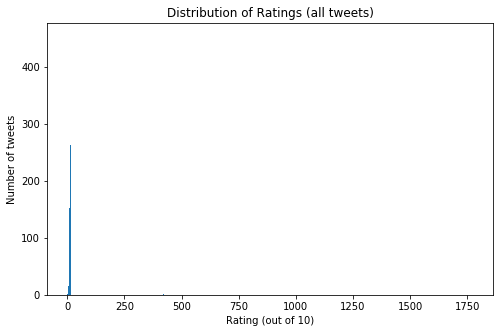

In [61]:
# visualizing the rating distribution
plt.figure(figsize = [8, 5])
bin_edges = np.arange(0, dogs_analysis['rating_numerator'].max()+1, 1)
plt.hist(data = dogs_analysis, x = 'rating_numerator', bins = bin_edges)
plt.title('Distribution of Ratings (all tweets)')
plt.xlabel('Rating (out of 10)')
plt.ylabel('Number of tweets');

Clearly, this distribution has some outliers. From the assessment I remember a tweet with numerator 1776, I will quickly assess all *rating_numerators* using .value_counts()

In [62]:
# assessing rating_numerators
dogs_analysis.rating_numerator.value_counts()

12.00      455
10.00      421
11.00      403
13.00      262
9.00       152
8.00        96
7.00        51
14.00       36
6.00        32
5.00        31
3.00        19
4.00        15
2.00         8
1.00         4
0.00         2
1776.00      1
9.75         1
13.50        1
11.26        1
11.27        1
420.00       1
Name: rating_numerator, dtype: int64

Right, I will exclude the two extreme values (1776 and 420), and visualize the distribution again: 

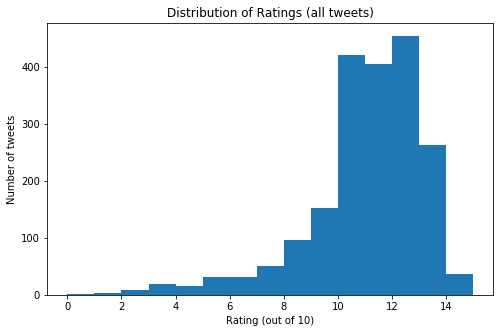

In [63]:
# visualizing the rating distribution without outliers
ratings_no_outliers = dogs_analysis.query('rating_numerator < 20')

plt.figure(figsize = [8, 5])
bin_edges = np.arange(0, ratings_no_outliers['rating_numerator'].max()+2, 1)
plt.hist(data = ratings_no_outliers, x = 'rating_numerator', bins = bin_edges)
plt.title('Distribution of Ratings (all tweets)')
plt.xlabel('Rating (out of 10)')
plt.ylabel('Number of tweets');

As the visualization shows, the distribution is left-skewed. The most common rating is a 12/10. Now, let's have a look at the average rating: 

In [64]:
ratings_no_outliers.rating_numerator.describe()

count    1991.000000
mean       10.565434
std         2.164696
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

Excluding outliers, the average rating is a 10.6/10. 75% of all ratings are at 10/10 or higher.

#### Average rating for tweets rating dogs vs non-dogs

Again, I am excluding extreme outliers, and only looking at tweets with a rating below 20. 

In [65]:
# getting dogs: p1_dog == True
dogs = dogs_analysis[(dogs_analysis.p1_dog == True) &
                    (dogs_analysis.rating_numerator < 20)]

# getting non-dogs: p1_dog == False
non_dogs = dogs_analysis[(dogs_analysis.p1_dog == False)&
                    (dogs_analysis.rating_numerator < 20)]

To begin with, let's visualize the rating distributions for dogs vs non-dogs:

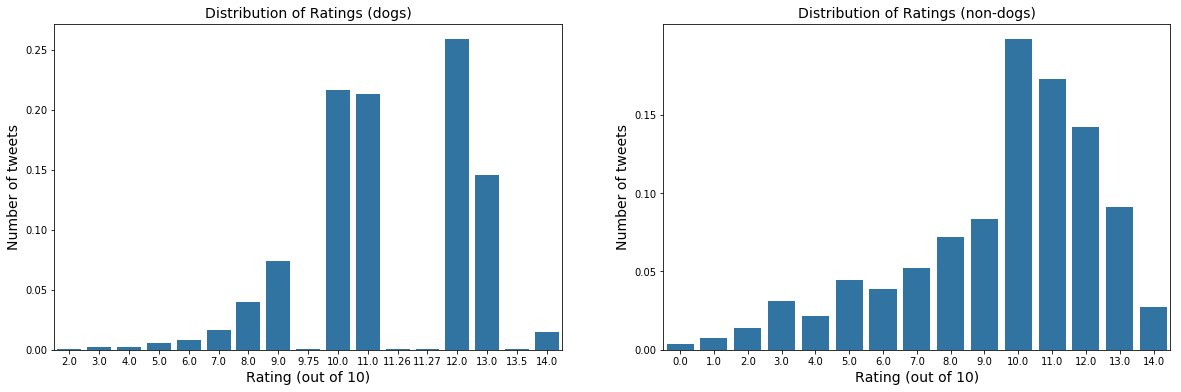

In [66]:
base_color = sns.color_palette()[0]

# plotting as proportions 
n_points_dogs = dogs.shape[0]
max_count_dogs = dogs['rating_numerator'].value_counts().max()
max_prop_dogs = max_count_dogs / n_points_dogs
# generate tick mark locations and names
tick_props_dogs = np.arange(0, max_prop_dogs, 0.05)
tick_names_dogs = ['{:0.2f}'.format(v) for v in tick_props_dogs]

n_points_non_dogs = non_dogs.shape[0]
max_count_non_dogs = non_dogs['rating_numerator'].value_counts().max()
max_prop_non_dogs = max_count_non_dogs / n_points_non_dogs
# generate tick mark locations and names
tick_props_non_dogs = np.arange(0, max_prop_non_dogs, 0.05)
tick_names_non_dogs = ['{:0.2f}'.format(v) for v in tick_props_non_dogs]

plt.figure(figsize = [20, 6]) 
# dogs
plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
sns.countplot(data = dogs, x = 'rating_numerator', color = base_color)
plt.yticks(tick_props_dogs * n_points_dogs, tick_names_dogs)
plt.xlabel('Rating (out of 10)', fontsize=14)
plt.ylabel('Number of tweets', fontsize=14)
plt.title('Distribution of Ratings (dogs)', fontsize=14)

# non-dogs
plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
sns.countplot(data = non_dogs, x = 'rating_numerator', color = base_color)
plt.yticks(tick_props_non_dogs * n_points_non_dogs, tick_names_non_dogs)
plt.xlabel('Rating (out of 10)', fontsize=14)
plt.ylabel('Number of tweets', fontsize=14)
plt.title('Distribution of Ratings (non-dogs)', fontsize=14)
plt.show();

Neglecting the decimal values, the distribution of dog ratings for dogs looks similar to the distribution for all tweets. The non-dogs add some very low ratings (0/10 and 1/10), ratings below 10/10 are more common than for dogs. The most common rating for dogs is 12/10, for non-dogs it is 10/10. Next, let's compare the averages: 

In [67]:
dogs.rating_numerator.describe()

count    1476.000000
mean       10.932778
std         1.681058
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

In [68]:
non_dogs.rating_numerator.describe()

count    515.000000
mean       9.512621
std        2.921365
min        0.000000
25%        8.000000
50%       10.000000
75%       12.000000
max       14.000000
Name: rating_numerator, dtype: float64

The average dog rating is at 10.9/10, the average non-dog rating at 9.5/10. 

#### Average ratings over time

Next, I want to see if WeRateDogs rating behavior changed over time. To adequately evaluate this, I am going to use a 30-day moving average. To exclude outliers, I will group the ratings b day and represent each day with its *rating_numerators*' median.  

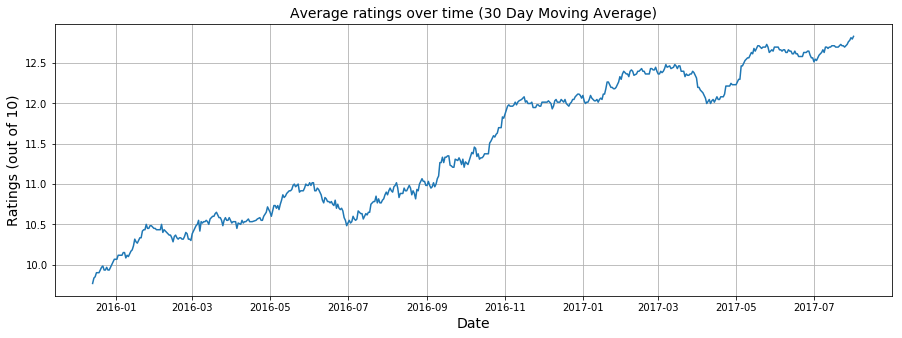

In [69]:
# roughly inspired by: https://towardsdatascience.com/moving-averages-in-python-16170e20f6c

# get ratings sorted by time
rating_over_time = dogs_analysis[['timestamp', 'rating_numerator']].sort_values(by='timestamp')

# ensure valid datatype
rating_over_time.timestamp = pd.to_datetime(rating_over_time.timestamp)
rating_over_time.timestamp = rating_over_time.timestamp.dt.date

# group ratings by date, represent them by median
rating_over_time = rating_over_time.groupby('timestamp').rating_numerator.median()

# calculate moving average
rating_over_time = rating_over_time.rolling(window=30).mean()

# plot the ratings vs time
rating_over_time.plot(figsize=[15,5])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Ratings (out of 10)', fontsize=14)
plt.title('Average ratings over time (30 Day Moving Average)', fontsize=14)
plt.grid(True)
plt.show();

WeRateDogs' *rating_numerators* definitely increased in time! Starting out with a 10/10 average rating, the account arrived at an average rating over 12.5 in June and July 2017. 

To further illustrate this and verify my visualization, I will retrieve the average rating in July 2017:

In [70]:
time_dogs = dogs_analysis[['timestamp', 'rating_numerator']].sort_values(by='timestamp')
time_dogs.timestamp = pd.to_datetime(time_dogs.timestamp)

# https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates
july_17_dogs = time_dogs[(time_dogs['timestamp'] > '2017-07-01') & (time_dogs['timestamp'] < '2017-07-30')]

july_17_dogs.rating_numerator.mean()

12.819148936170214

<a id='RQ2'></a>
### Research Question 2: Which dog breed is most popular?

To evaluate the most popular dog breed, I am again interested in multiple facets. "Most popular" is a rather broad spectrum, and can be interpreted in different ways. Therefore, I want to determine:
- The dog breed which is rated most often
- The dog breed with the highest average rating
- The dog breed with the highest favorite count
- The dog breed with the highest retweet count

To retrieve the dog breeds, I will again use the image predictions. This time, I am using both the p1_conf and p1_dog features. To base my breed categorisation on a certain level of confidence, I will use a specific confidence level as cut-off for which categorisations the evaluation is based on. 

As a first step, I am going to assess the distribution of *p1_conf*.

In [71]:
# assessing p1 confidence score
dogs_analysis.p1_conf.describe()

count    1993.000000
mean        0.593802
std         0.271951
min         0.044333
25%         0.362835
50%         0.587507
75%         0.845256
max         1.000000
Name: p1_conf, dtype: float64

Only 25% of dogs have a p1_confidence score of over 0.84. This means, that by taking the confidence level into consideration, I will reduce my dataset significantly. Still, I will use the cut-off, and set it at 0.85. 

In [72]:
confident_predictions = dogs_analysis[(dogs_analysis.p1_dog == True) &
                                     (dogs_analysis.p1_conf >= 0.85)]

print('{} breed predictions have a p1 confidence level at or over 0.85.'.format(len(confident_predictions)))

371 breed predictions have a p1 confidence level at or over 0.85.


#### Dog breed with most dog ratings

In [73]:
# get top 5 breeds: most tweeted about
most_tweets = confident_predictions.groupby(['p1'], as_index=False)['tweet_id'].count().sort_values(
    ascending=False, by='tweet_id')

top5_most_tweets = most_tweets.head(5)
top5_most_tweets

p1  tweet_id
57    golden_retriever        53
30            Pembroke        31
64                 pug        28
22  Labrador_retriever        27
35             Samoyed        22

The dog breed with the highest number of dog ratings is Golden Retriever, with 53 tweets. In the top 5 of dog breeds with most tweets, Golden Retrievers are followed by Pembrokes, Pugs, Labrador Retrievers, and Samoyeds. Let's have a look at the highest rated Golden Retriever:

In [74]:
#getting tweet text for top-rated golden retriever
golden_retrievers = confident_predictions.query('p1 == "golden_retriever"')
top_rated_golden_retrievers = golden_retrievers.sort_values(
    ascending=False, by='rating_numerator')
top_rated_golden_retrievers.text.iloc[0]

'This is Ollie Vue. He was a 3 legged pupper on a mission to overcome everything. This is very hard to write. 14/10 we will miss you Ollie https://t.co/qTRY2qX9y4'

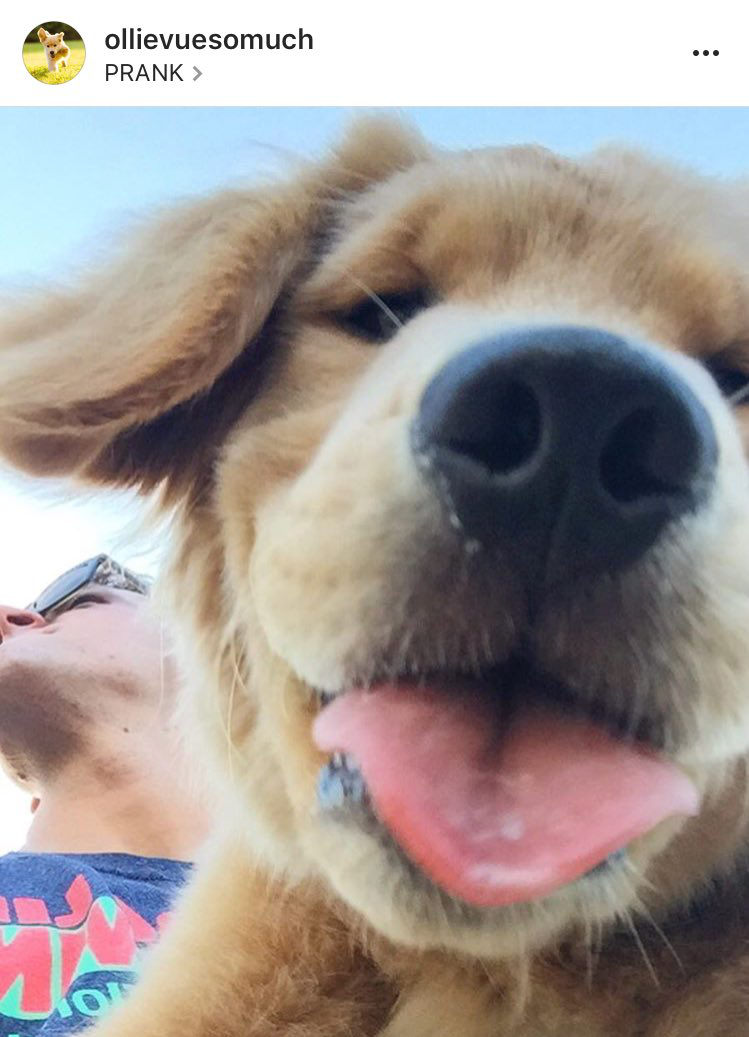

In [75]:
# getting image of most favorited dog
url = top_rated_golden_retrievers.jpg_url.iloc[0]
response = requests.get(url)
Image.open(BytesIO(response.content))

#### Dog breed with best average ratings

In [76]:
# get top 5 breeds: best average rating
best_rating = confident_predictions.groupby(['p1'], as_index=False)['rating_numerator'].mean().sort_values(
    ascending=False, by='rating_numerator')

top5_best_rating = best_rating.head(5)
top5_best_rating

p1  rating_numerator
17            Gordon_setter              14.0
46  black-and-tan_coonhound              14.0
0              Afghan_hound              13.0
50                   briard              13.0
24                 Leonberg              13.0

The highest rated dog breeds are Gordon Setters and Black and Tan Coonhounds, with an average rating of 14. Let's have a look at the highest rated dog:

In [77]:
#getting tweet text for top-rated dog:
top_rated = confident_predictions.sort_values(
    ascending=False, by='rating_numerator')
display(top_rated.p1.iloc[0])
display(top_rated.text.iloc[0])

'Gordon_setter'

'We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10\n\nhttps://t.co/XQlmPTLHPl https://t.co/ZNIkkHgtYE'

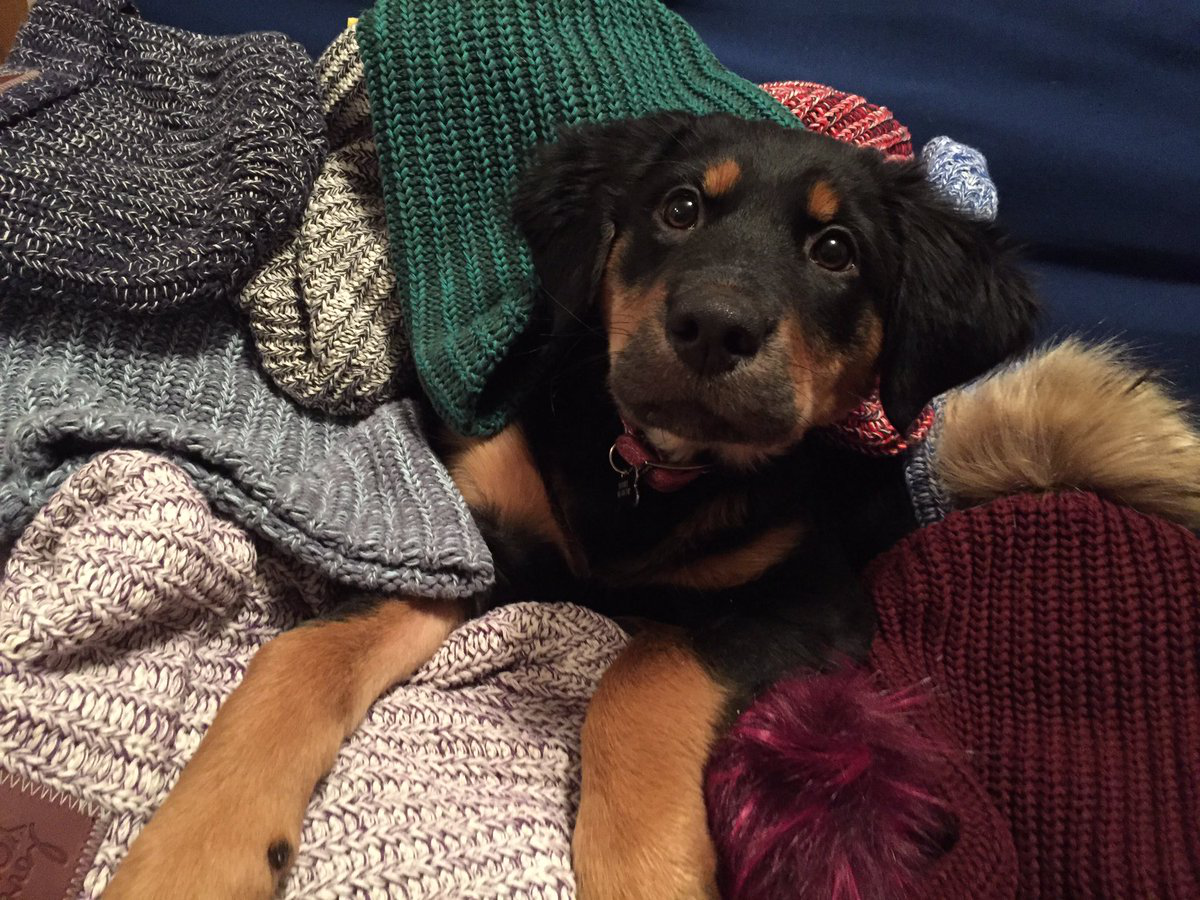

In [78]:
# getting image of most favorited dog
url = top_rated.jpg_url.iloc[0]
response = requests.get(url)
Image.open(BytesIO(response.content))

#### Dog breed with highest favorite count

In [79]:
# get top 5 breeds: highest favorite count
most_favorites = confident_predictions.groupby(['p1'], as_index=False)['favorite_count'].sum().sort_values(
    ascending=False, by='favorite_count')

top5_most_favorites = most_favorites.head(5)
top5_most_favorites

p1  favorite_count
57    golden_retriever        624206.0
30            Pembroke        414443.0
22  Labrador_retriever        338158.0
14      French_bulldog        271971.0
35             Samoyed        261849.0

The favorite count dog breed top 5 is similar to the one for "Most tweets". Again, it is topped by Golden Retrievers, with over 600k favorites. Pembroke, Samoyed, and Labrador Retriever are again in the top 5, Pugs have been replaced by French Bulldogs. Let's have a look at the most favorited dog:

In [80]:
# getting tweet text for most favorited dog:
most_favorited = confident_predictions.sort_values(
    ascending=False, by='favorite_count')
display(most_favorited.p1.iloc[0])
display(most_favorited.text.iloc[0])

'French_bulldog'

'This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr'

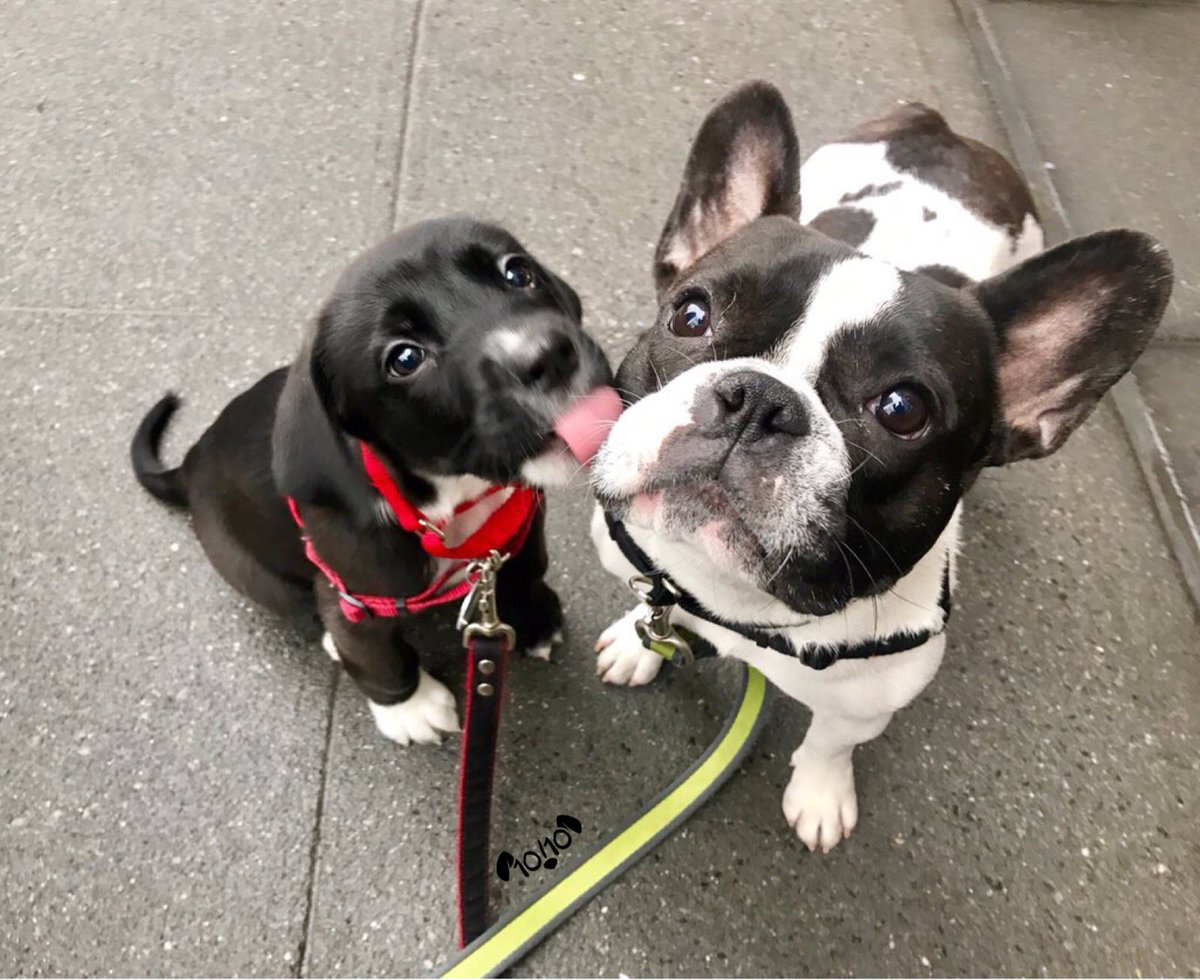

In [81]:
# getting image of most favorited dog
url = most_favorited.jpg_url.iloc[0]
response = requests.get(url)
Image.open(BytesIO(response.content))

Surprisingly, the most favorited dog is not a Golden Retriever, but a pupper kissing a French Bulldog. 

#### Dog breed with highest retweet count

In [82]:
# get top 5 breeds: highest favorite count
most_retweets = confident_predictions.groupby(['p1'], as_index=False)['retweet_count'].sum().sort_values(
    ascending=False, by='retweet_count')

top5_most_retweets = most_retweets.head(5)
top5_most_retweets

p1  retweet_count
57    golden_retriever       168984.0
30            Pembroke       115229.0
22  Labrador_retriever        97391.0
35             Samoyed        86034.0
14      French_bulldog        68253.0

The retweet count dog breed top 5 sequence is identical to the one for favorite count. Let's have a look at the dog with the most retweets:

In [83]:
#getting tweet text for most retweeted dog:
most_retweets = confident_predictions.sort_values(
    ascending=False, by='retweet_count')
display(most_retweets.p1.iloc[0])
display(most_retweets.text.iloc[0])

'French_bulldog'

'This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr'

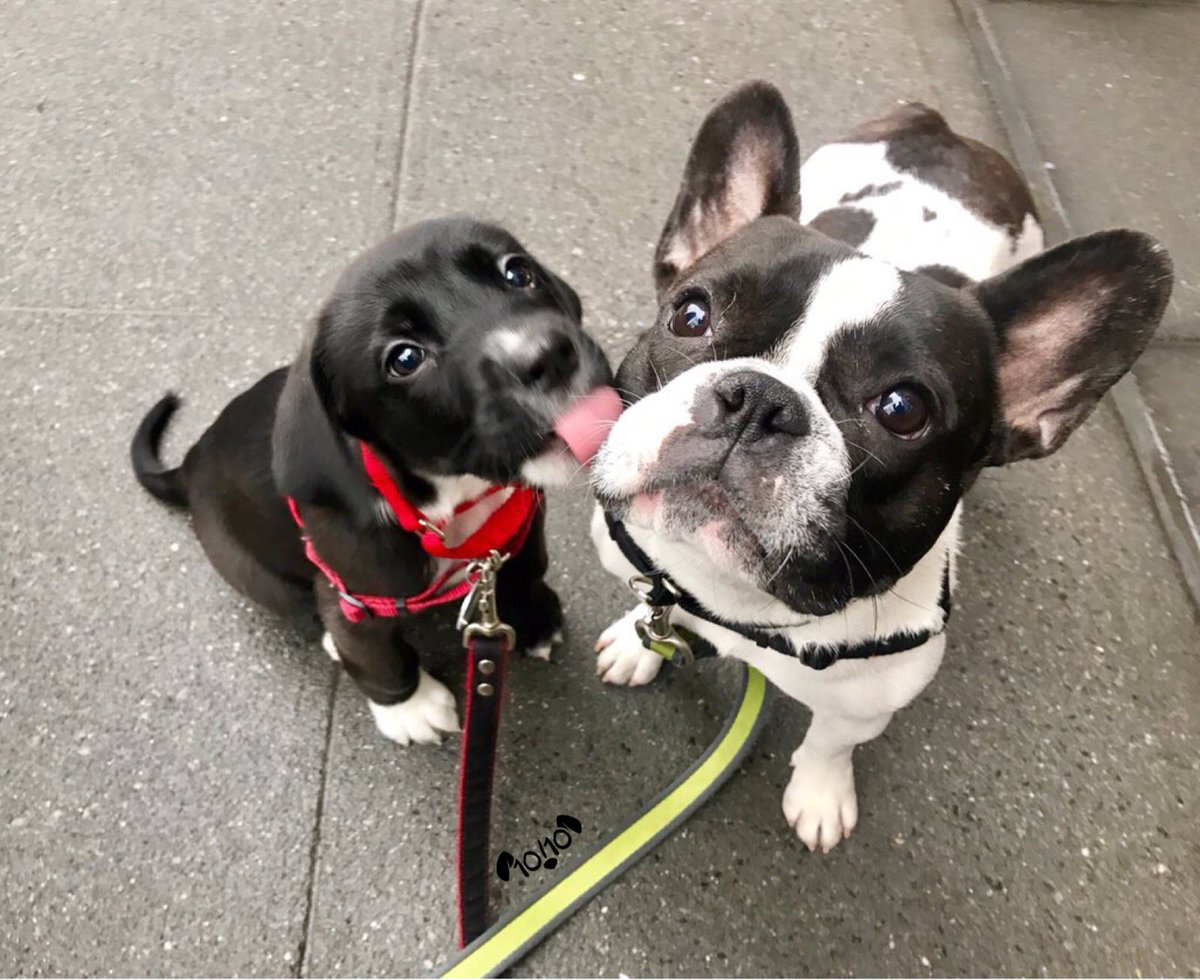

In [84]:
# getting image of most retweeted dog
url = most_retweets.jpg_url.iloc[0]
response = requests.get(url)
Image.open(BytesIO(response.content))

Again, the dog with the highest retweet count is not a Golden Retriever, but the dog kissing a French Bulldog that also received the most favorites.

<a id='RQ3'></a>
### Research Question 3: Is there a relationship between number of retweets, number of favorites and ratings?

Judging from the similar results for retweets and favorites in the dog breed insights, one could assume a correlation between retweet count and favorite count. Next, I want to evaluate if this holds for the whole *dogs_analysis* dataset, and if there is a relationship between these two variables and the ratings. 

To answer these questions, I am going to create a correlation matrix of *retweet_count*, *favorite_count*, and *rating_numerator*.

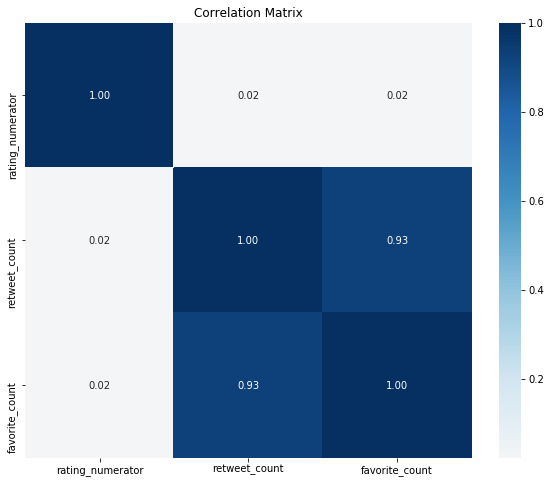

In [85]:
retweet_favorite_rating = dogs_analysis[['rating_numerator', 'retweet_count', 'favorite_count']]

# visualizing the correlation between retweet_count, favorite_count and rating_numerator
plt.figure(figsize = [10, 8])
plt.title('Correlation Matrix')
sns.heatmap(retweet_favorite_rating.corr(), annot = True, fmt = '.2f', cmap = 'RdBu', center = 0);

There is no correlation between ratings and *favorite_count* respectively *retweet_count*. As assumed, there is a strong positive correlation between favorites and retweets. 

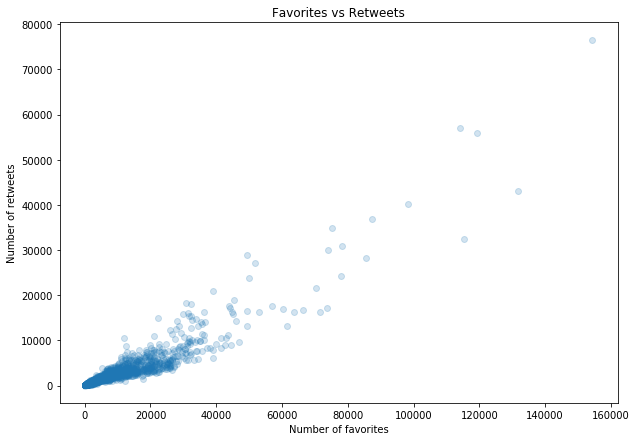

In [86]:
# visualizing the relationship of favorite_count and retweet_count in a scatterplot
plt.figure(figsize=[10, 7])
plt.scatter(data = dogs_analysis, x = 'favorite_count', y = 'retweet_count', alpha = 0.2)
plt.xlabel('Number of favorites')
plt.ylabel('Number of retweets')
plt.title('Favorites vs Retweets')
plt.show();

The scatterplot confirms the positive relationship between the two features. A higher favorite count is correlated with a higher retweet_count.

<a id='conclusion'></a>
## Conclusion

This project aimed to wrangle and analyze a dataset based on the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. The analysis was based on a dataset created from three data sources:
- WeRateDogs twitter_archive, including information on ratings, dog names, tweet text and image etc.
- Tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.
- Additional tweet data gathered from the Twitter API (favorite count, retweet count)

These datasets were assessed for data quality and data tidiness, cleaned accordingly, and then used as information-basis to answer the following questions: 
1. What is the average dog rating? Has the average rating changed over time?
2. Which dog breed is most popular?
3. Is there a relationship between number of retweets, number of favorites and ratings?

WeRateDogs' average rating is a 10.6/10. 75% of all ratings are at 10/10 or higher. The average rating for tweets rating dogs (as per the image prediction) is 10.9/10, the average non-dog rating at 9.5/10. The average rating has increased over time, from 10/10 in the beginning of 2016 to 12.8 in July 2017. 

The dog breed that is most tweeted about, and has the highest aggregated favorite count and retweet count is the Golden Retriever. The highest rated dog breed, with on average 14/10, is a Gordon Setter. The most retweeted and favorited tweet shows a pupper kissing a French Bulldog. 

Ratings are not correlated to favorite counts and retweet counts. Favorite count and retweet count have a strong positive correlation.